In [1]:
import pandas as pd
import numpy as np
import re
from functools import reduce

import seaborn as sns
from matplotlib import pyplot as plt
import textwrap

from sklearn.model_selection import train_test_split

pd.options.display.max_columns=None
pd.options.display.max_colwidth=310
pd.options.mode.chained_assignment=None

In [2]:
# Dataset completo procesado
ruta='data/formacion_procesado.csv'
df=pd.read_csv(ruta,index_col=0,low_memory=False)

# Naive decision tree

**Clasificador de ocupaciones a partir de títulos al estilo de un arbol de decisión**, con la diferencia de que, en lugar de identificar el punto de corte más explicativo en cada etapa, este clasificador solo reparte en ramas una vez y crea **tantas ramas como títulos distintos** haya en el dataset de entrenamiento.   

Para cada título identifica todas las ocupaciones, las ordena de más a menos frecuentes y  selecciona como predicción las ocupaciones en el **top n del ranking de frecuencias** que, además, estén por encima de un **umbral de frecuencia relativa establecido como mínimo**.   

Para cada título, este clasificador devuelve como **predicción una lista de ocupaciones ordenadas** de más a menos probables y las **probabilidades asociadas** a cada ocupación.   

## Parámetros del modelo

Los parámetros de este modelo son n, el **número máximo de posiciones en el ranking de ocupaciones** que se seleccionan como predictores, y el **umbral de frecuencia mínima**.   

El número de ocupaciones en la predicción para cada título puede ser mayor o menor que  n, el número de posiciones en el ranking de frecuencias que se tienen en cuenta:   

- Si alguna ocupación en el top n del ranking tiene una frecuencia inferior al umbral, se descarta como predictor. Así, es posible que la lista de ocupaciones seleccionadas tenga menos de n elementos.  

- Cuando hay empates entre ocupaciones en el top n de frecuencias, se incluyen en la predicción todas las que pertenecen al grupo empatado. Esto hace posible que se seleccionen más de n ocupaciones como predicción. 

## Entrenamiento, validación y test

En las **etapas iniciales** del proceso de construcción del clasificador se han empleado los datos de la **encuesta completa**. Se ha hecho así porque las primeras etapas son un **análisis descriptivo** del dataset que informa de las frecuencias de títulos y ocupaciones y de la distribución de las de ocupaciones distintas asociadas a cada título. Al aplicar el análisis sobre los datos de la encuesta completa obtenemos información poblacional sobre estas relaciones.   
  
Para las fases de entrenamiento y predicción se ha separado el dataset en tres subconjuntos: **train, validación y test**.    
  
El conjunto de **train** se obtiene como resultado de un **muestreo aleatorio estratificado** que garantiza una presencia de todos los títulos proporcional a la observada en la encuesta. No obstante, se han realizado pruebas sobre un conjunto de train seleccionado aleatoriamente sin estratificación. Los resultados de estas pruebas no difieren dramáticamente de los obtenidos con muestreo estratificado.   
  
Para la selección de los subconjuntos de **validación** y de **test** se ha buscado un **muestreo aleatorio no estratificado** para evitar que la similitud excesiva de las distribuciones de títulos en los tres conjuntos influya en la medición de la capacidad predictiva del clasificador. 

Las **proporciones** del tamaño de la encuesta que representan las observaciones seleccionadas en train, validación y test se fijan en 0.6, 0.2 y 0.2 respectivamente. 

El funcionamiento del algoritmo y el diseño de las métricas de evaluación se han ilustrado empleando las **columnas de título y de ocupacion literales** (strings) en lugar de las nuḿericas. Se ha decidido así porque facilita el hacerse una idea de cuáles son las titulaciones para las que es más o menos probable hacer predicciones acertadas durante el proceso de construcción del clasificador. No obstante, el diseño del algoritmo permite sutituir las columnas literales por las numéricas para operar de forma más eficiente. También permite establecer otros regresores y targets distintos de los títulos y las ocupaciones. 


## Objetivos del modelo

El principal objetivo de la construcción de un clasificador elemental es **conocer en qué medida las titulaciones universitarias de grado y de máster explican por sí solas las profesiones que alcanzan los titulados**.    
  
Se espera un éxito modesto por varios motivos:   

- Los títulos universitarios no son el único critero de los empleadores para seleccionar a su plantilla. Por un lado, un título universitario suele ser insuficiente por sí solo para aspirar a un buen número de puestos de trabajo reservados a universitarios. Por otro lado, a menudo los candidatos a un empleo pueden suplir la falta de un título universitario especializado con otros méritos, como la experiencia profesional o la formación en disciplinas afines. Los estudios de medicina son una excepción clara a esta posibilidad; los resultados constatan que las profesiones sanitarias están reservadas a titulados con formación especializada (aunque no todos los que tienen esa formación trabajan en ocupaciones relacionadas con su título). 


- Las encuestas empleadas en este proyecto solo informan con detalle de un **único título universitario de cada encuestado**. Aquellos que han accedido a su profesión gracias a un título distinto del que les hace elegibles para la encuesta en la que participan (otro grado, otro máster, un título de doctor) se escapan a la capacidad predictiva de los modelos basados en estos datos.  Esto se notará especialmente en los casos en los que el encuestado responde sobre un título que ha estudiado por motivos distintos a búsqueda de empleo o la promoción profesional mientras trabajaban en ocupaciones a las que accedieron gracias a una titulación previa.  


- El mal funcionamiento del mercado de trabajo español empuja a muchos aspirantes a un empleo a aceptar trabajos poco o nada relacionados con su formación y sus conocimientos.   

Los resultados del modelo sirven también al objetivo de **identificar las titulaciones que tienen relaciones más estrechas con las ocupaciones** más frecuentes de los titulados y aquellas otras para las cuales la capacidad del título como predicctor de la profesión futura es más pobre. 


## Justificación

**Ventajas de la construcción del algoritmo a medida** (en lugar de emplear una solución estándar):  

- **Simplicidad** de la justificación teórica que sustenta las predicciones. Facilita la interpretación de los resultados.  
  
  
- Clasificador **específico** para un modelo con un **único regresor** en el que, además, **el regresor y el target son variables categóricas**.  


- **Flexibilidad** para definir los criterios de agregación de las métricas de evaluación, por titulaciones (o categorías del regresor) o por ocupaciones (categorías del target). En particular, emplear un único regresor permite obtener mediciones del accuracy desagregadas para cada uno de los títulos observados en el proceso de evaluación. Esto facilita la identificación de los títulos y las profesiones para las que es más y menos probable hacer predicciones acertadas.   
  
  
- **Flexibilidad** para incorporar un número variable de precicciones para cada título a las métricas de accuracy, recall y precisión y para ajustar estas métricas de acuerdo con las probabilidades asignadas a las distintas predicciones.  
   

- El proceso de construcción del algoritmo es, en su mayor parte, un **análisis descriptivo** de las relaciones entre titulaciones y ocupaciones. Este análisis se ha ilustrado y probado con los datos de la encuesta completa para **estimar la dificultad del problema de clasificación** (que se resuelve, más adelante, sobre subconjuntos de train, validación y test).  

# Dataset encuesta 

#### Observaciones con target informado

In [3]:
# Selección: solo ocupaciones informadas
df=df[df['ocupacion'].notna()]
df.shape

(59844, 356)

#### Número de categorías distintas del target: 

In [4]:
df['ocupacion'].nunique()
# Ocupaciones distintas (núm. categorías del target):

62

#### Número de categorías distintas del regresor: 

In [5]:
df['titulo_ppal_'].nunique()
# Titulos distintos (num. categorías del regresor principal): 

173

# 1. Distribución del número de ocupaciones distintas por título

### Regresor y target:
En adelante se identifican el título principal como regresor y la ocupación como target. Esto facilitará la generalización del clasificador naive a otros targets y regresores. 

In [225]:
def num_cat_targets_por_cat_regresor(data,regresor,target):
    
    """ Cuenta el número de categorías distintas del target para cada categoría del regresor
    """
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['nunique'])
    out.columns=out.columns.to_flat_index() 
    out.rename(columns={out.columns[-1]:'num categorias target para regresor'},inplace=True)
    out.sort_values(by='num categorias target para regresor',inplace=True)
    out.reset_index(inplace=True)
    
    return out

In [7]:
num_oc_por_titulo_encuesta=num_cat_targets_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_oc_por_titulo_encuesta.head(10)

,titulo_ppal_,num categorias target para regresor
0,Grado Odontología,5
1,Máster Odontología,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",8
3,Máster Religión y teología,9
4,Máster Lenguas (Otros estudios),10
5,Grado Medicina,10
6,Máster Veterinaria,10
7,Grado Protocolo y eventos,11
8,Máster Estadística,11
9,Máster Enfermería,11


In [8]:
num_oc_por_titulo_encuesta.tail(10)

,titulo_ppal_,num categorias target para regresor
163,"Grado Ingeniería agrícola, agropecuaria y medio rural",50
164,Grado Actividad física y del deporte,50
165,Grado Trabajo social,51
166,Grado Educación infantil,52
167,Grado Ciencias ambientales,52
168,Grado Educación primaria,52
169,Grado Economía,53
170,Grado Historia,53
171,Grado Arquitectura técnica,53
172,Grado Administración y empresa,54


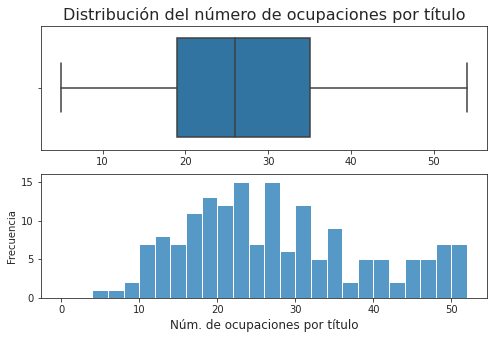

In [9]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(2, 1,figsize=(8,5))
font_titles=16
font_labels=12

sns.boxplot(ax=ax1,data=num_oc_por_titulo_encuesta,
            x='num categorias target para regresor')
ax1.set_title('Distribución del número de ocupaciones por título',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

max_num_oc=num_oc_por_titulo_encuesta['num categorias target para regresor'].max()

sns.histplot(ax=ax2,data=num_oc_por_titulo_encuesta,
             x='num categorias target para regresor',
             bins=np.arange(0,max_num_oc,2))

ax2.set_xlabel('Núm. de ocupaciones por título',fontsize=font_labels)
ax2.set_ylabel('Frecuencia',fontsize=font_labels-2)
ax2.set_ylim(0,16)

fig.subplots_adjust(hspace=.2)
plt.show()

## 1.1. Número de ocupaciones distintas por título: resumen 

In [10]:
# Distribución del número de ocupaciones por título: resumen
ocupaciones_tt=pd.DataFrame(num_oc_por_titulo_encuesta['num categorias target para regresor'].describe())
ocupaciones_tt.rename(columns={'num categorias target para regresor':
                               'Distribución núm. de ocupaciones distintas por título'},inplace=True)
ocupaciones_tt

,Distribución núm. de ocupaciones distintas por título
count,173.000000
mean,27.705202
std,12.290563
min,5.000000
25%,19.000000
50%,26.000000
75%,35.000000
max,54.000000


## 1.2. Número de ocupaciones distintas por rama de conocimento

Exploración de la distribución del número de ocupaciones distintas para cada título para los títulos agregados por ramas de conocimiento.

In [11]:
# df auxiliar para añadir ramas de conocimiento a la distribución de número de ocupaciones por título:
df_ramas=df[['titulo_ppal_','rama_ppal_']].drop_duplicates()
df_ramas.head()

,titulo_ppal_,rama_ppal_
0,Grado Pedagogía,Ciencias sociales y jurídicas
568,Grado Educación infantil,Ciencias sociales y jurídicas
1933,Grado Educación primaria,Ciencias sociales y jurídicas
3840,Grado Otros maestros,Ciencias sociales y jurídicas
4007,Grado Educación social,Ciencias sociales y jurídicas


In [12]:
# df auxiliar para añadir ramas de conocimiento a la distribución de número de ocupaciones por título:
num_oc_por_titulo_ramas=num_oc_por_titulo_encuesta.merge(df_ramas,on='titulo_ppal_',how='left')

# Orden de acuerdo con mediana y mínimo de núm. categorías target para regresor para boxplot:
aux_ordena=num_oc_por_titulo_ramas[['rama_ppal_','num categorias target para regresor']]\
                    .groupby('rama_ppal_').agg(['median','min'])
aux_ordena.columns=aux_ordena.columns.to_flat_index()
aux_ordena.rename(columns=({aux_ordena.columns[-2]:'mediana'}),inplace=True)
aux_ordena.rename(columns=({aux_ordena.columns[-1]:'min'}),inplace=True)

num_oc_por_titulo_ramas=num_oc_por_titulo_ramas.merge(aux_ordena,on='rama_ppal_',how='left')
num_oc_por_titulo_ramas.sort_values(by=['mediana','min'],inplace=True)
num_oc_por_titulo_ramas.head()

,titulo_ppal_,num categorias target para regresor,rama_ppal_,mediana,min
0,Grado Odontología,5,Ciencias de la salud,19,5
1,Máster Odontología,6,Ciencias de la salud,19,5
5,Grado Medicina,10,Ciencias de la salud,19,5
6,Máster Veterinaria,10,Ciencias de la salud,19,5
9,Máster Enfermería,11,Ciencias de la salud,19,5


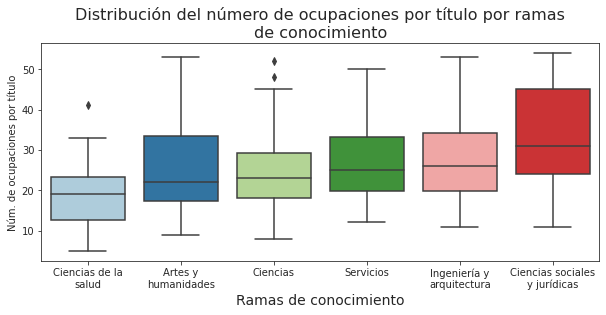

In [226]:
fig, ax = plt.subplots(1, 1,figsize=(10,4))
font_titles=16
font_labels=14

ax = sns.boxplot(data=num_oc_por_titulo_ramas, 
                 x='rama_ppal_',
                 y='num categorias target para regresor',
                 palette='Paired')

titulo='Distribución del número de ocupaciones por título por ramas de conocimiento'
ax.set_title(textwrap.fill(titulo,60), fontsize=font_titles)
ax.set_xlabel('Ramas de conocimiento',fontsize=font_labels)
ax.set_ylabel('Núm. de ocupaciones por título')
ax.set_xticklabels(textwrap.fill(tick.get_text(),18) for tick in ax.get_xticklabels())

plt.show()

## 1.3. Número de ocupaciones distintas por familia de estudios

Exploración del número de ocupaciones distintas por título para los títulos agregados por familias de estudios. 

In [14]:
# df auxiliar para añadir familias de estudios a la distribución de número de ocupaciones por título:
df_familias=df[['titulo_ppal_','familia_ppal_']].drop_duplicates()
df_familias.head()

,titulo_ppal_,familia_ppal_
0,Grado Pedagogía,Educación
568,Grado Educación infantil,Educación
1933,Grado Educación primaria,Educación
3840,Grado Otros maestros,Educación
4007,Grado Educación social,Educación


In [15]:
# df auxiliar para añadir familias de estudios a la distribución de número de ocupaciones por título:
num_oc_por_titulo_familias=num_oc_por_titulo_encuesta.merge(df_familias,on='titulo_ppal_',how='left')

# Orden de acuerdo con mediana de núm. categorías target para regresor:
aux_ordena=num_oc_por_titulo_familias[['familia_ppal_','num categorias target para regresor']]\
                    .groupby('familia_ppal_').agg(['median'])
aux_ordena.columns=aux_ordena.columns.to_flat_index()
aux_ordena.rename(columns=({aux_ordena.columns[-1]:'mediana'}),inplace=True)

num_oc_por_titulo_familias=num_oc_por_titulo_familias.merge(aux_ordena,on='familia_ppal_',how='left')
num_oc_por_titulo_familias.sort_values(by='mediana',inplace=True)
num_oc_por_titulo_familias.head()

,titulo_ppal_,num categorias target para regresor,familia_ppal_,mediana
162,Grado Informática,50,Informática,16.0
31,Máster Diseño y administración de bases de datos y redes,16,Informática,16.0
32,Máster Tecnologías de la información y las comunicaciones (Otros estudios),16,Informática,16.0
11,Grado Desarrollo de software y de aplicaciones e Ingeniería multimedia,12,Informática,16.0
60,Máster Desarrollo y análisis de aplicaciones y de software,21,Informática,16.0


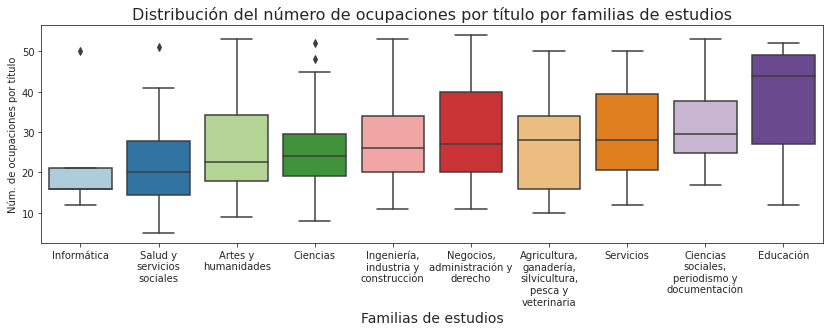

In [227]:
fig, ax = plt.subplots(1, 1,figsize=(14,4))
font_titles=16
font_labels=14

ax = sns.boxplot(data=num_oc_por_titulo_familias, 
                 x='familia_ppal_',\
                 y='num categorias target para regresor',
                 palette='Paired')

ax.set_title('Distribución del número de ocupaciones por título por familias de estudios',fontsize=font_titles)
ax.set_ylabel('Núm. de ocupaciones por título')
ax.set_xlabel('Familias de estudios',fontsize=font_labels)
ax.set_xticklabels(textwrap.fill(tick.get_text(),16) for tick in ax.get_xticklabels())

plt.show()

### Observación: 

El número de ocupaciones observadas y el número de encuestados para cada título tienen una relación directa. Esta relación es más intensa cuanto menor es el número de titulados encuestados.  

Por ejemplo, en el caso de la familia de estudios de Informática, solo hay un título con más de 500 encuestados, el grado en Informática, para el que se observan 50 ocupaciones distintas, lo que le situa como un valor extremo en el gráfico de cajas y bigotes de su familia de estudios.  

A continuación se explora la relación entre el número de encuestados y el número de ocupaciones con más detalle. 

# 2. Número de titulados (observaciones) por título

Se explora la relación entre el número de encuestados (o titulados) y el número de ocupaciones distintas observadas para cada título. 

In [17]:
def num_obs_por_cat_regresor(data,regresor,target):
    
    """ Cuenta el número de categorías del target y el número de observaciones para cada categoría del regresor. 
    """
    
    columnas=[regresor,target]
    out=data[columnas].groupby([regresor]).agg(['count'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs regresor'},inplace=True)
    
    previo=num_cat_targets_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=out.merge(previo,on=regresor,how='outer')
    out=out.sort_values(by='num categorias target para regresor')
    out.reset_index(drop=True,inplace=True)
    
    return out

In [229]:
num_titulados_encuesta=num_obs_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_titulados_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor
0,Grado Odontología,243,5
1,Máster Odontología,73,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8
3,Máster Religión y teología,25,9
4,Máster Lenguas (Otros estudios),53,10


In [230]:
num_titulados_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor
168,Grado Educación primaria,2065,52
169,Grado Economía,1174,53
170,Grado Historia,697,53
171,Grado Arquitectura técnica,1050,53
172,Grado Administración y empresa,2637,54


## 2.1. Número de titulados por título: resumen 

In [231]:
# Distribución del número de encuestados (o titulados) por titulo: resumen
encuestados_tt=pd.DataFrame(num_titulados_encuesta['obs regresor'].describe())
encuestados_tt.rename(columns={'obs regresor':'Distribución núm. de encuestados por título'},inplace=True)
encuestados_tt

,Distribución núm. de encuestados por título
count,173.000000
mean,345.919075
std,477.144211
min,23.000000
25%,90.000000
50%,154.000000
75%,355.000000
max,2637.000000


## 2.2. Número de titulados y número de ocupaciones por título

In [232]:
# df auxiliar: se añaden columnas para la rama de conocimiento y para la familia de estudios de cada título: 
num_titulados_encuesta=num_titulados_encuesta.merge(df_ramas,on='titulo_ppal_',how='left')
num_titulados_encuesta=num_titulados_encuesta.merge(df_familias,on=['titulo_ppal_'],how='left')
num_titulados_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,rama_ppal_,familia_ppal_
0,Grado Odontología,243,5,Ciencias de la salud,Salud y servicios sociales
1,Máster Odontología,73,6,Ciencias de la salud,Salud y servicios sociales
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8,Ciencias,Ciencias
3,Máster Religión y teología,25,9,Artes y humanidades,Artes y humanidades
4,Máster Lenguas (Otros estudios),53,10,Artes y humanidades,Artes y humanidades


In [233]:
# Columna auxiliar para ordenar boxplot por mediana y mínimo del número de ocupaciones distintas: 
num_titulados_encuesta.rename(columns={'num categorias target para regresor':'num cat'},inplace=True)
aux_mediana_cat=num_titulados_encuesta[['rama_ppal_','num cat']].groupby('rama_ppal_').agg(['median'])
aux_mediana_cat.columns=aux_mediana_cat.columns.to_flat_index()
aux_mediana_cat.rename(columns={aux_mediana_cat.columns[-1]:'mediana cat'},inplace=True)
aux_mediana_cat.sort_values(by='mediana cat')

num_titulados_encuesta=num_titulados_encuesta.merge(aux_mediana_cat,on='rama_ppal_',how='left')

num_titulados_encuesta.sort_values(by='mediana cat',inplace=True)
#num_titulados_encuesta

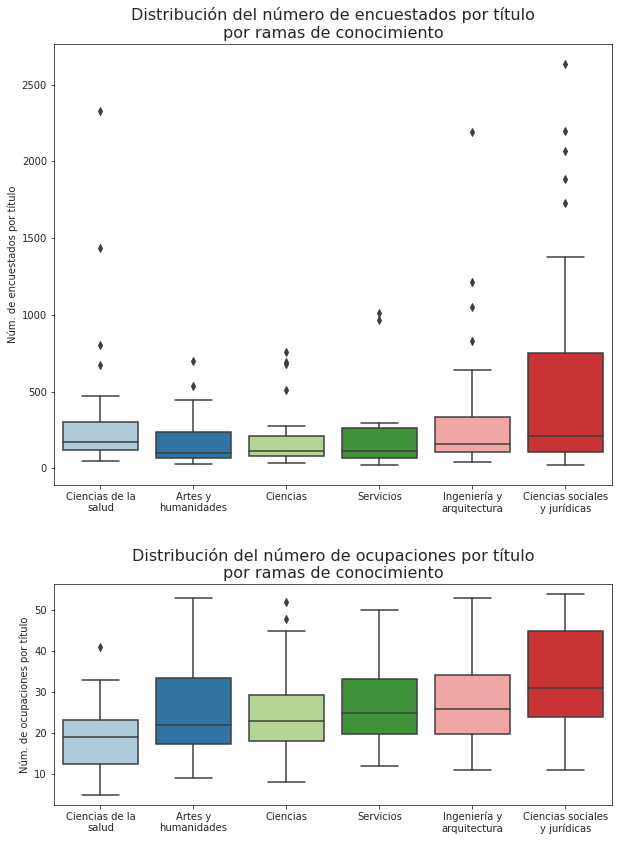

In [234]:
from matplotlib import gridspec

fig= plt.figure(figsize=(10, 14)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 2]) 

cols=['obs regresor','num cat']

for i,col in enumerate(cols):

    ax=plt.subplot(gs[i])
    sns.boxplot(data=num_titulados_encuesta, 
                     x='rama_ppal_',
                     y=col,
                     palette='Paired')

    titulos=['Distribución del número de encuestados por título por ramas de conocimiento',
             'Distribución del número de ocupaciones por título por ramas de conocimiento']
    y_labels=['Núm. de encuestados por título', 'Núm. de ocupaciones por título']
    ax.set_title(textwrap.fill(titulos[i],50), fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel(y_labels[i])
    ax.set_xticklabels(textwrap.fill(tick.get_text(),18) for tick in ax.get_xticklabels())

fig.subplots_adjust(hspace=0.3)
plt.show()

### Observación: 

Los gráficos de cajas y bigotes del número de titulados y el número de ocupaciones para cada título agrupados por ramas de conocimiento sugiere una relación directa entre encuestados y ocupaciones observadas excepto para la rama de Ciencias de la salud. Para el resto de ramas se observa que la mediana del número de ocupaciones crece con la mediana del número de encuestados. También se aprecia que esta relación no tiene la misma intensidad para todas las ramas de conocimiento.  

Para explorar esta relación, se representa a continuación el número de encuestados y de ocupaciones para cada título y se analizan los resultados para cada familia de estudios. 

In [26]:
# Columnas auxiliares para plot por familias de estudios: 
aux_dumm_familias=pd.get_dummies(data=num_titulados_encuesta,columns=['familia_ppal_'],
                                 prefix='Familia',prefix_sep=' ')
#aux_dumm_familias.head()

In [235]:
# Títulos abreviados:
D_titulos_abreviados={'Máster Formación de docentes de educación secundaria y formación profesional':
                     'Máster Formación docentes ES y FP'}
aux_dumm_familias['titulo_ppal_'].replace(D_titulos_abreviados,inplace=True)
#aux_dumm_familias

In [243]:
# Coordenadas de títulos con más de un número mínimo de encuestados min_obs: 
lista_familias=num_titulados_encuesta['familia_ppal_'].unique().tolist()

min_obs=500 

puntos=list()
for familia in lista_familias:
    aux_tts=aux_dumm_familias[aux_dumm_familias['Familia '+familia]==1]
    aux_tts=aux_tts[aux_tts['obs regresor']>min_obs]
    puntos.append(list(zip(aux_tts['obs regresor'],aux_tts['num cat'],aux_tts['titulo_ppal_'])))  
#puntos

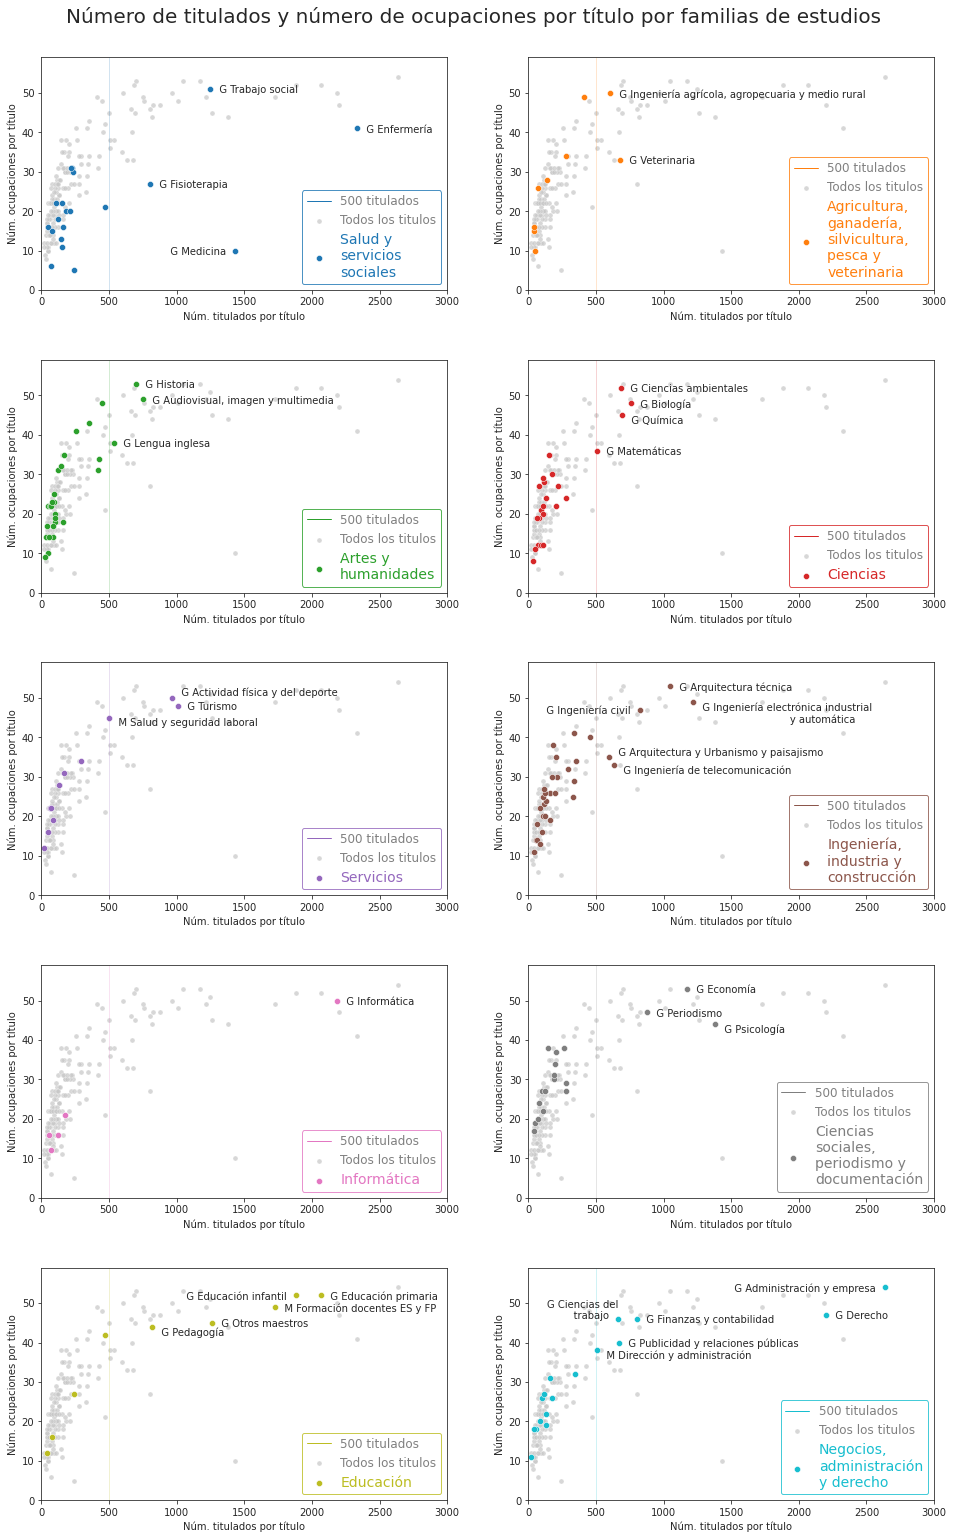

In [291]:
sns.set_style('ticks')

paleta=sns.color_palette('tab20')

criterio='familia_ppal_'

fig, axes = plt.subplots(5, 2,figsize=(16,24))
font_titles=20
font_labels=10

titulo_1='Número de titulados y número de ocupaciones por título por familias de estudios'
fig.suptitle(titulo_1,fontsize=font_titles,va='baseline')

for i,clase in enumerate(num_titulados_encuesta[criterio].unique()):
    
    dummy='Familia '+clase
    data=aux_dumm_familias[['obs regresor','num cat',dummy]]
    
    # Coordenadas de cada gráfico en axes: 
    a1=i//2 
    a2=i%2 

    sns.scatterplot(ax=axes[a1,a2],data=data,
                x='obs regresor',
                y='num cat',
                color=paleta.as_hex()[15],alpha=0.7,s=25) # todos los títulos
    
    sns.scatterplot(ax=axes[a1,a2],data=data[data[dummy]==1],
                x='obs regresor',
                y='num cat',
                color=paleta.as_hex()[i*2],s=37) # familia
    
    sns.lineplot(ax=axes[a1,a2],
                x=np.array([min_obs]*2),
                y=np.array([0,59]),
                color=paleta.as_hex()[i*2], linewidth=1) # recta x=min_obs
    
    # Titulos con más de 500 encuestados: 
    for tt in puntos[lista_familias.index(clase)]: 
        texto='   '+tt[2].split(' ',1)[0][0]+' '+tt[2].split(' ',1)[1]
        # Ajustes posición: 
        if tt[2] in ['Grado Medicina','Grado Administración y empresa','Grado Ingeniería civil',
                     'Grado Educación infantil'] :
            texto=texto+'   '
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='center_baseline',ha='right')
        elif tt[2] in ['Grado Química','Grado Pedagogía','Máster Salud y seguridad laboral',
                      'Grado Ingeniería de telecomunicación','Grado Psicología',
                       'Máster Dirección y administración']:
            texto=texto+'   '
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='top')    
        elif tt[2] in ['Grado Actividad física y del deporte','Grado Arquitectura y Urbanismo y paisajismo']:
            texto=texto+'   '
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='bottom')
        elif tt[2]=='Grado Ingeniería electrónica industrial y automática':
            texto='   G Ingeniería electrónica industrial\n                               y automática'
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='top')
        elif tt[2]=='Grado Ciencias del trabajo':
            texto='G Ciencias del\n     trabajo   '
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,ha='right')
        else:
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='center_baseline')
    
    axes[a1,a2].set_xlabel('Núm. titulados por título',fontsize=font_labels)
    axes[a1,a2].set_ylabel('Núm. ocupaciones por título',fontsize=font_labels)
    axes[a1,a2].set_xlim(0,3000)
    axes[a1,a2].set_ylim(0,59)
    
    leyenda=axes[a1,a2].legend([str(min_obs)+' titulados','Todos los titulos',textwrap.fill(clase,15)],
                               loc='lower right',fontsize='large',edgecolor=paleta.as_hex()[i*2])
    for color,text in zip(['grey','grey',paleta.as_hex()[i*2]],leyenda.get_texts()):
        text.set_color(color)
    for size,text in zip([12,12,14],leyenda.get_texts()):
        text.set_size(size)
        
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(top=0.96)
plt.show()

### Observaciones: 

- Se constata una **relación directa entre el número de encuestados (o titulados) y el número de ocupaciones distintas observadas para cada titulo**.  
    
    
- Esta relación es **más intensa cuanto menor es el número de encuestados**: para los títulos con solo unos pocos cientos de encuestados, el número de categorías observadas es casi proporcional al número de titulados consultados. Sin embargo, cuando el número de encuestados es suficientemente alto, el número de ocupaciones se estabiliza. En otras palabras, llega un momento en el que no por preguntar a más titulados se obtienen más respuestas diferentes sobre sus ocupaciones.   
  
  
- El análisis del **coeficiente de correlación lineal** del número de encuestados y el número de ocupaciones confirma esta conclusión: el coeficiente de correlación ronda el valor 0.7 cuando se calcula para toda la muestra, desciende hasta 0.24 cuando se excluyen las titulaciones con menos de 500 encuestados y se reduce hasta 0.1 cuando solo se tienen en cuenta los títulos con más de 1000 encuestados (véanse los resultados exactos a continuación).  
   
   
- El **grado en Medicina** es una excepción a esta regla: a pesar de tener un número de encuestados muy superior al tercer cuartil, el número de ocupaciones observadas para el título es muy inferior al primer cuartil de la distribución del número de ocupaciones distintas (véanse los valores exactos a continuación).  

In [30]:
# Correlación número de encuestados y núm. de ocupaciones: muestra completa
num_titulados_encuesta[['obs regresor', 'num cat']].corr()

,obs regresor,num cat
obs regresor,1.000000,0.695259
num cat,0.695259,1.000000


In [31]:
# Correlación número de encuestados y núm. de ocupaciones: títulos con más de 500 encuestados: 
num_titulados_encuesta[['obs regresor', 'num cat']][num_titulados_encuesta['obs regresor']>500].corr()

,obs regresor,num cat
obs regresor,1.000000,0.239282
num cat,0.239282,1.000000


In [32]:
# Correlación número de encuestados y núm. de ocupaciones: títulos con más de 1000 encuestados
num_titulados_encuesta[['obs regresor', 'num cat']][num_titulados_encuesta['obs regresor']>1000].corr()

,obs regresor,num cat
obs regresor,1.000000,0.099846
num cat,0.099846,1.000000


In [228]:
# Exploración grado en Medicina: excepción a la relación directa entre núm. encuestados y núm. de ocupaciones
distribuciones_tt=encuestados_tt.merge(ocupaciones_tt,left_index=True,right_index=True)
medicina_encuestados=int(aux_dumm_familias[aux_dumm_familias['titulo_ppal_']=='Grado Medicina']['obs regresor'])
medicina_ocupaciones=int(aux_dumm_familias[aux_dumm_familias['titulo_ppal_']=='Grado Medicina']['num cat'])
distribuciones_tt.loc['Grado Medicina','Distribución núm. de encuestados por título']=medicina_encuestados
distribuciones_tt['Distribución núm. de ocupaciones distintas por título'].loc['Grado Medicina']\
                 =medicina_ocupaciones
distribuciones_tt

,Distribución núm. de encuestados por título,Distribución núm. de ocupaciones distintas por título
count,173.000000,173.000000
mean,345.919075,27.705202
std,477.144211,12.290563
min,23.000000,5.000000
25%,90.000000,19.000000
50%,154.000000,26.000000
75%,355.000000,35.000000
max,2637.000000,54.000000
Grado Medicina,1433.000000,10.000000


# 3. Número de profesionales por título y ocupación

El clasificador de ocupaciones a partir de los títulos universitarios selecciona como predicción para cada título las ocupaciones más frecuentes de sus titulados. 

A continuación se cuenta, para cada título, el número de profesionales de cada ocupación. Esto permite calcular la frecuencia relativa de cada ocupación para cada título y la frecuencia relativa acumulada asociada a una ordenación decreciente de las frecuencias relativas, también título a título. 

In [34]:
def num_cat_target_por_regresor_y_target(data,regresor,target):
    
    """Cuenta, para cada cagegoría del regresor, el número de observaciones, el número de categorías distintas
    del target y el número de observaciones de cada categoría del target. 
    """
    
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['value_counts'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs target'},inplace=True)
    
    previo=num_obs_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=previo.merge(out,on=regresor,how='outer')
    out.sort_values(by=['num categorias target para regresor','obs target'],ascending=[True,False],inplace=True)
    
    return out

In [35]:
prof_por_oc_y_titulo_encuesta=num_cat_target_por_regresor_y_target(data=df,
                                                                   regresor='titulo_ppal_',target='ocupacion_')
prof_por_oc_y_titulo_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target
0,Grado Odontología,243,5,Prof sanitarios,237
1,Grado Odontología,243,5,Gerentes en servicios excepto hostelería y comercio,2
2,Grado Odontología,243,5,Prof enseñanza,2
3,Grado Odontología,243,5,Directores producción y operaciones,1
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1


In [36]:
prof_por_oc_y_titulo_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1


## 3.1. Proporción de profesionales sobre titulados por ocupación y título

Se calculan las frecuencias relativas y frecuencias relativas acumuadas de las ocupaciones para cada título. Para calcular las frecuencias acumuladas se ordenan las ocupaciones observadas para cada título por frecuencia relativa en orden descendente. 

In [37]:
def frecuencias_cat_target_por_regresor(data,regresor,target):
    
    """Calcula la frecuencia relativa con la que se observa cada categoría del target asociada a cada categoría 
    del regresor como proporción del número de observaciones de cada combinación de categoría de regresor y de 
    target sobre el número de observaciones de la categoría del regresor. 
    Y calcula las frecuencias relativas acumuladas (o proporciones acumuladas) para las ocupaciones asociadas a 
    la misma categoría ordenadas de mayor a menor de acuerdo con su frecuencia relativa.
    """
    
    previo=num_cat_target_por_regresor_y_target(data=data,regresor=regresor,target=target)
    # 'prop' = proporción de obs. del target sobre núm. obs. para la categoría del regresor: 
    previo['prop']=previo['obs target'].div(previo['obs regresor'])
    
    # Frecuencias acumuladas: 
    acum=previo[[regresor,'prop']].groupby(regresor).cumsum()
    acum.rename(columns={acum.columns[-1]:'prop acum'},inplace=True)
    
    out=previo.merge(acum,left_index=True,right_index=True,how='outer')
    
    
    return out

In [38]:
proporciones_encuesta=frecuencias_cat_target_por_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
proporciones_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309
1,Grado Odontología,243,5,Gerentes en servicios excepto hostelería y comercio,2,0.008230,0.983539
2,Grado Odontología,243,5,Prof enseñanza,2,0.008230,0.991770
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000


In [39]:
proporciones_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1,0.000379,1.000000


## 3.2. Ranking de ocupaciones por título

Se ordenan las ocupaciones asociadas a cada título en un ranking de más a menos frecuentes. En caso de empate se asigna a todas las ocupaciones con el mismo número de observaciones la posición en el ranking mínima del conjunto empatado. 

In [40]:
def ranking_cat_target_por_cat_regresor(data,regresor,target):
    
    """Para cada categoría del regresor, identifica el ranking de ocupaciones ordenadas de más a menos frecuentes.
    Los empates se resuelven imputando a todas las categorías del target empatadas el valor mínimo de las 
    posiciones del grupo.
    """
    
    previo=frecuencias_cat_target_por_regresor(data=data,regresor=regresor,target=target)
    rank=previo[[regresor,'obs target']]
    rank=rank.groupby(regresor).rank(method='min',ascending=False)
    rank.rename(columns={rank.columns[-1]:'rank'},inplace=True)
    
    out=previo.merge(rank,how='outer',left_index=True,right_index=True)
    out.sort_values(by=['num categorias target para regresor','rank'],inplace=True)
    
    return out 

In [41]:
ranking_encuesta=ranking_cat_target_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
ranking_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum,rank
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309,1.0
1,Grado Odontología,243,5,Gerentes en servicios excepto hostelería y comercio,2,0.008230,0.983539,2.0
2,Grado Odontología,243,5,Prof enseñanza,2,0.008230,0.991770,2.0
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885,4.0
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000,4.0


In [42]:
ranking_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum,rank
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483,48.0
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862,48.0
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242,48.0
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621,48.0
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1,0.000379,1.000000,48.0


# 4. Ranking de ocupaciones más frecuentes por título (clasificador naive) 

Se fija el **número de posiciones en el ranking de frecuencias relativas que se incluirán en la predicción** de ocupaciones para cada título. Este parámetro se denomina **max_rank**. 
 
El criterio elegido para resolver los empates implica que, cuando se estos se produzcan en posiciones inferiores al valor max_rank, todas las ocupaciones empatadas serán incluidas en la predicción. Esto puede causar que el número de ocupaciones predichas para algún título sea mayor que el parámetro max_rank. 

Se define también un **umbral mínimo de frecuencia relativa, min_prop**, para que una ocupación se incluya entre las predicciones para un título. 

Así, el número de predicciones para un título será inferior al parámetro max_rank cuando el número de ocupaciones distintas para ese título sea inferior a max_rank o cuando alguna de las ocupaciones en las primeras posiciones del ranking de frecuencias tenga una frecuencia relativa inferior al umbral min_prop. 

Se define la función **naive_fit**, equivalente al proceso de entrenamiento del modelo.

In [44]:
def naive_fit(data,regresor,target,max_rank,min_prop):
    
    """Para cada categoría del regresor, selecciona las que ocupan una posición en el raking de frecuencias por 
    debajo del parámetro max_rank que, además, tengan una frecuencia relativa superior al parámetro min_prop.
    """
    
    previo=ranking_cat_target_por_cat_regresor(data=data,regresor=regresor,target=target)
    
    naive=previo[previo['rank']<=max_rank]
    naive=naive[naive['prop']>=min_prop]
    
    naive.sort_values(by=['num categorias target para regresor',regresor,'rank'],inplace=True)
    naive.reset_index(drop=True,inplace=True)
    naive.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)
    
    return naive

In [45]:
# Inspección de los resultados del entrenamiento en la encuesta completa: 
naive_encuesta=naive_fit(data=df,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)
naive_encuesta.sample(2)

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
355,Grado Bioquímica,220,27,Técnicos ciencias e ingenierías,16,0.072727,0.681818,3.0
146,Máster Aprendizaje de segundas lenguas,98,18,Prof cultura y espectáculo,17,0.173469,0.622449,2.0


In [46]:
# Inspección de los resultados del entrenamiento en la encuesta completa: 

#with pd.option_context("display.max_rows", naive_encuesta.shape[0]):
#    display(naive_encuesta)

# 5. Entrenamiento, validación y test

Se separan los dataset de train, validación y test sin distinguir regresores y target porque es más conveniente mantener todas las columnas en un dataframe único para aplicar el algoritmo y evaluar los resultados. 

Se realiza un **muestreo estratificado** para garantizar que las proporciones de cada título en el **conjunto de entrenamiento** son las mismas que se observan en la encuesta (una vez descartadas las observaciones con ocupación no informada, es decir, la población desempleada o inactiva). Se procede así porque las proporciones de los títulos en la encuesta del INE son el resultado de un muestreo estratificado sobre la población universitaria española. Conservando estas proporciones garantizamos que el conjunto de entrenamiento también es una representación adecuada de la población universitaria.  

Los **conjuntos de validación y de test** se extraen del complementario del conjunto de entrenamiento con un **muestreo aleatorio no estratificado**. Se ha procedido así con la intención de evitar que la composición excesivamente similar de los tres conjuntos influya más de lo inevitable en las métricas de evaluación del modelo. Una alternativa distinta que no se ha explorado es extraer los conjuntos de validación y de test de un proceso de bootstraping sobre el complementario del conjunto de entrenamiento. 

Las proporciones de los tamaños de los conjuntos de entrenamiento, validación y test en relación con el tamaño de la encuesta son 0.6, 0.2 y 0.2. 

Nota: También es razonable un **enfoque alternativo** al de considerar solo las filas de la encuesta para las que la ocupación está informada que consiste en incluir a la **población no ocupada**, y tratar a los desocupados y a los inactivos como dos categorías ḿas del target. Se ha elegido no incluir a la población no ocupada porque este enfoque responde mejor a la pregunta en qué trabajan los que estudian eso. 

In [295]:
# Conjunto de entrenamiento y su complementario: 
df_train, df_train_c= train_test_split(df,test_size=0.4,random_state=23,stratify=df['titulo_ppal'])

In [296]:
# Inspección: 
df_train.shape[0]/df.shape[0]

0.5999933159548159

In [297]:
# Conjuntos de validación y de test: 
df_vld, df_test= train_test_split(df_train_c,test_size=0.5,random_state=23)

In [298]:
# Inspección: 
df_vld.shape[0]/df.shape[0], df_test.shape[0]/df.shape[0]

(0.20000334202259207, 0.20000334202259207)

# 6. Predicciones 

In [50]:
def naive_predice_instrumental(clasificador,valor_regresor):
    """ Predicciones y probabilidades para el valor del regresor según el clasificador entrenado.
    Conserva el número de categorías del target para cada categoría del regresor para usarlo en evaluación.
    """
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0]
    
    modelo=clasificador[clasificador[regresor]==valor_regresor]
    prediccion=modelo[[target,'prop','num categorias target para regresor']]
    prediccion.reset_index(drop=True,inplace=True)
    prediccion.rename(columns={target:'prediccion','prop':'probabilidad'},inplace=True)
    
    return prediccion

In [51]:
def naive_predice(clasificador,valor_regresor):
    """ Predicción en el formato en el que se muestra al interesado
    """
    prediccion=naive_predice_instrumental(clasificador,valor_regresor)
    prediccion=prediccion[['prediccion','probabilidad']]

    return prediccion

In [52]:
# Fit en train:
naive_5_05_train=naive_fit(data=df_train,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)
naive_5_05_train.head()  

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
0,Máster Odontología,46,3,Prof sanitarios,42,0.913043,0.913043,1.0
1,Máster Odontología,46,3,Prof enseñanza,3,0.065217,0.978261,2.0
2,Grado Odontología,155,5,Prof sanitarios,149,0.961290,0.961290,1.0
3,Máster Veterinaria,32,6,Prof sanitarios,15,0.468750,0.468750,1.0
4,Máster Veterinaria,32,6,Técnicos ciencias e ingenierías,5,0.156250,0.625000,2.0


In [53]:
naive_5_05_train.tail()

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
688,Grado Administración y empresa,1688,51,Prof derecho,92,0.054502,0.601303,5.0
689,Grado Historia,446,52,Prof enseñanza,100,0.224215,0.224215,1.0
690,Grado Historia,446,52,Prof eduación especial y no reglada,30,0.067265,0.291480,2.0
691,Grado Historia,446,52,Prof ciencias sociales,25,0.056054,0.347534,3.0
692,Grado Historia,446,52,Prof cultura y espectáculo,24,0.053812,0.401345,4.0


In [54]:
# Inspección: 
naive_predice_instrumental(clasificador=naive_5_05_train,valor_regresor='Máster Odontología')

,prediccion,probabilidad,num categorias target para regresor
0,Prof sanitarios,0.913043,3
1,Prof enseñanza,0.065217,3


In [55]:
# Inspección: 
naive_predice(naive_5_05_train,valor_regresor='Grado Economía')

,prediccion,probabilidad
0,"Empleados servicios financieros, contables y de apoyo",0.262317
1,Prof ciencias sociales,0.110519
2,"Expertos en gestión, finanzas, comercio, etc",0.106525
3,Empleados administrativos sin atención al público,0.067909
4,Otros empleados administrativos con atención al público,0.065246


In [56]:
# Inspección: 
naive_predice(naive_5_05_train,valor_regresor='Grado Matemáticas')

,prediccion,probabilidad
0,Prof enseñanza,0.343558
1,"Prof ciencias, matemáticas e ingeniería",0.177914
2,Técnicos TI,0.116564
3,Profesionales IT,0.107362
4,Prof eduación especial y no reglada,0.052147


In [57]:
# Inspección: Ilustra empate múltiple
naive_predice(naive_5_05_train,valor_regresor='Máster Servicios de transporte')

,prediccion,probabilidad
0,"Prof ciencias, matemáticas e ingeniería",0.238095
1,Técnicos ciencias e ingenierías,0.119048
2,"Empleados servicios financieros, contables y de apoyo",0.071429
3,Representantes e intermediarios,0.071429
4,"Supervisores ingeniería, industria y construcción",0.071429


# Evaluación del clasificador

In [58]:
def naive_evalua(clasificador, data):
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0].split(' ')[1]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0].split(' ')[1]
    
    # evalua: dataset con regresores y targets en el set de evaluación
    evalua=data[[regresor,target]]
    
    # Columnas con predicciones (lista targets predichos y lista probabilidades)
    evalua['prediccion']=evalua[regresor]\
                .apply(lambda valor: naive_predice_instrumental(clasificador,valor)['prediccion'].tolist())
    evalua['prediccion probs']=evalua[regresor]\
                .apply(lambda valor: naive_predice_instrumental(clasificador,valor)['probabilidad'].tolist())
    
    # Núm predicciones:
    evalua['num pred por regresor']=evalua['prediccion'].apply(lambda lista:len(lista))
    
    # Núm. categorías del target por regresor en el set de train:
    evalua['cat target por regresor (train)']=evalua[regresor]\
            .apply(lambda valor:\
            naive_predice_instrumental(clasificador,valor)['num categorias target para regresor'].unique()[0])

    # Columna 'acierto' (binaria)
    evalua['acierto']=evalua.apply(lambda row: row[target] in row['prediccion'],axis=1).astype(int)
    
    # Posición de predicción acertada: 
    evalua['posicion acierto']=evalua[evalua['acierto']==1]\
                              .apply(lambda row: row['prediccion'].index(row[target])+1,axis=1)
    
    # Columna 'probabilidad asociada la predicción acertada' (numerador de acierto ajustado por probabilidad):
    evalua['prob pred acertada']=evalua[evalua['acierto']==1]\
                            .apply(lambda row: row['prediccion probs'][int(row['posicion acierto'])-1],axis=1)
    
    # Columna 'suma de probabilidades de predicciones' (denominador de acierto ajustado por probabilidad):
    evalua['suma prob prediccion']=evalua['prediccion probs'].apply(lambda lista: sum(lista))
    
    # Acierto ajustado: proporción de la probabilidad de predicción acertada sobre suma probs. de predicciones:  
    evalua['acierto ajustado']=evalua[evalua['acierto']==1]['prob pred acertada']\
                              .div(evalua[evalua['acierto']==1]['suma prob prediccion'])
    
    
    del evalua['prediccion probs']
    
    # Num. de observaciones para cada categoría del regresor:
    total_obs_por_cat_regresor=evalua[[regresor,'acierto']].groupby(regresor).agg(['count'])
    total_obs_por_cat_regresor.columns=total_obs_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num obs regresor'},inplace=True)
    
    # Núm. de aciertos (binaria) para cada categoría del regresor: 
    aciertos_por_cat_regresor=evalua[[regresor,'acierto']].groupby(regresor).agg(['sum'])
    aciertos_por_cat_regresor.columns=aciertos_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num aciertos por cat regresor'},inplace=True)
    
    # Suma aciertos ajustados por prob para cada categoría del regresor: 
    acierto_ajustado_por_cat_regresor=evalua[[regresor,'acierto ajustado']].groupby(regresor).agg(['sum'])
    acierto_ajustado_por_cat_regresor.columns=acierto_ajustado_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(acierto_ajustado_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por cat regresor'},inplace=True)
    
    # Accuracy y accuracy ajustado para cada categoría del regresor: 
    evalua['accuracy regresor']=evalua['num aciertos por cat regresor'].div(evalua['num obs regresor'])
    evalua['accuracy ajustado regresor']=evalua['aciertos ajustados por cat regresor']\
                                        .div(evalua['num obs regresor'])
    
    total_obs=evalua.shape[0]
    
    # Accuracy y accuracy ajustado poderados de cada categoría del regresor: 
    evalua['peso regresor']=evalua['num obs regresor']/total_obs
    evalua['accuracy ponderado regresor']=evalua['accuracy regresor']*evalua['peso regresor']
    evalua['accuracy ajustado ponderado regresor']=evalua['accuracy ajustado regresor']*evalua['peso regresor']
    
    # Num. de observaciones para cada categoría del target:
    total_obs_por_cat_target=evalua[[target,'acierto']].groupby(target).agg(['count'])
    total_obs_por_cat_target.columns=total_obs_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num obs target'},inplace=True)
    
    # Núm. de aciertos (binaria) para cada categoría del target: 
    aciertos_por_cat_target=evalua[[target,'acierto']].groupby(target).agg(['sum'])
    aciertos_por_cat_target.columns=aciertos_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num aciertos por cat target'},inplace=True)
    
    # Suma aciertos ajustados por prob para cada categoría del target: 
    acierto_ajustado_por_cat_target=evalua[[target,'acierto ajustado']].groupby(target).agg(['sum'])
    acierto_ajustado_por_cat_target.columns=acierto_ajustado_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(acierto_ajustado_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por cat target'},inplace=True)
  
    # Recall y recall ajustado para cada categoría del target:
    evalua['recall target']=evalua['num aciertos por cat target'].div(evalua['num obs target'])
    evalua['recall ajustado target']=evalua['aciertos ajustados por cat target'].div(evalua['num obs target'])
    
    # Recall y recall ajustado ponderados para cada categoría del target: 
    evalua['peso target']=evalua['num obs target']/total_obs
    evalua['recall ponderado target']=evalua['recall target']*evalua['peso target']
    evalua['recall ajustado ponderado target']=evalua['recall ajustado target']*evalua['peso target']
    
    # Formato:
    evalua.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)
    
    return evalua

### Evaluación desagregada (en train):

In [59]:
naive_5_05_evalua_train=naive_evalua(clasificador=naive_5_05_train, data=df_train)
naive_5_05_evalua_train.sample(2)

,regresor: titulo_ppal_,target: ocupacion_,prediccion,num pred por regresor,cat target por regresor (train),acierto,posicion acierto,prob pred acertada,suma prob prediccion,acierto ajustado,num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
7157,Grado Turismo,"Telefonista, recepcionista, telefonista, agencias de viaje, etc","[Telefonista, recepcionista, telefonista, agencias de viaje, etc, Trabajadores servicios personales, Expertos en gestión, finanzas, comercio, etc, Otros empleados administrativos con atención al público, Representantes e intermediarios]",5,44,1,1.0,0.286595,0.539291,0.531429,649,350,118.211429,0.539291,0.182144,0.016945,0.009138,0.003086,680,246,106.273669,0.361765,0.156285,0.017755,0.006423,0.002775
38034,Máster Formación de docentes de educación secundaria y formación profesional,Recogedores residuos urbanos y ocupaciones elementales servicios,"[Prof enseñanza, Prof eduación especial y no reglada]",2,46,0,NaN,NaN,0.687444,NaN,1107,761,632.248357,0.687444,0.571137,0.028903,0.019869,0.016508,78,0,0.000000,0.000000,0.000000,0.002037,0.000000,0.000000


In [61]:
accuracy_global_train=naive_5_05_evalua_train['acierto'].sum()/naive_5_05_evalua_train['acierto'].count()
accuracy_global_train

0.6781462140992167

### Evaluación desagregada (en validación):

In [62]:
naive_5_05_evalua_vld=naive_evalua(clasificador=naive_5_05_train, data=df_vld)

In [63]:
naive_5_05_evalua_vld.head(2)

,regresor: titulo_ppal_,target: ocupacion_,prediccion,num pred por regresor,cat target por regresor (train),acierto,posicion acierto,prob pred acertada,suma prob prediccion,acierto ajustado,num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
0,Grado Periodismo,Prof enseñanza,"[Prof cultura y espectáculo, Expertos en gestión, finanzas, comercio, etc, Técnicos TI, Directores Admón y comerciales]",4,45,0,NaN,NaN,0.541071,NaN,140,83,34.254125,0.592857,0.244672,0.014621,0.008668,0.003577,1580,1400,956.548865,0.886076,0.605411,0.165013,0.146214,0.099901
1,Grado Periodismo,Prof enseñanza,"[Prof cultura y espectáculo, Expertos en gestión, finanzas, comercio, etc, Técnicos TI, Directores Admón y comerciales]",4,45,0,NaN,NaN,0.541071,NaN,140,83,34.254125,0.592857,0.244672,0.014621,0.008668,0.003577,1580,1400,956.548865,0.886076,0.605411,0.165013,0.146214,0.099901


In [64]:
accuracy_global_vld=naive_5_05_evalua_vld['acierto'].sum()/naive_5_05_evalua_vld['acierto'].count()
accuracy_global_vld

0.661201044386423

# Métricas de evaluación: accuracy

In [65]:
# Dataframe para pruebas de funciones de evaluación: 
df_prueba=pd.DataFrame({'titulo_ppal_':['Grado Derecho','Grado Derecho','Grado Derecho',
                                        'Grado Administración y empresa','Grado Medicina'],
                        'ocupacion_':['Prof derecho','Prof derecho',
                                      'Empleados servicios financieros, contables y de apoyo','Prof derecho',
                                      'Prof sanitarios']},
                       index=[50,51,52,53,54])

In [66]:
def naive_evalua_accuracy(clasificador,data):
    
    evalua=naive_evalua(clasificador=clasificador,data=data)
    
    import re
    lista_re_regresor=list(filter(lambda col: re.search('.*regresor.*',col),evalua.columns))
    lista_re_regresor=lista_re_regresor+['suma prob prediccion']
    
    evalua=evalua[lista_re_regresor].drop_duplicates()
    evalua.set_index(evalua.columns[0],inplace=True)
    evalua.sort_values(by='accuracy regresor',ascending=False,inplace=True)

    return evalua

In [67]:
prueba=naive_evalua_accuracy(clasificador=naive_5_05_train,data=df_prueba)
prueba

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion
regresor: titulo_ppal_,,,,,,,,,,,
Grado Derecho,4,43,3,3,1.421109,1.0,0.473703,0.6,0.6,0.284222,0.666667
Grado Administración y empresa,5,51,1,1,0.090640,1.0,0.090640,0.2,0.2,0.018128,0.601303
Grado Medicina,1,8,1,1,1.000000,1.0,1.000000,0.2,0.2,0.200000,0.986914


In [68]:
naive_5_05_evalua_accuracy_vld=naive_evalua_accuracy(clasificador=naive_5_05_train,data=df_vld)

In [69]:
naive_5_05_evalua_accuracy_vld.shape, df_vld['titulo_ppal_'].nunique() # Comprobación: 

((173, 11), 173)

In [70]:
naive_5_05_evalua_accuracy_vld.head()

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion
regresor: titulo_ppal_,,,,,,,,,,,
Máster Odontología,2,3,12,12,11.200000,1.0,0.933333,0.001253,0.001253,0.001170,0.978261
Máster Hostelería,10,10,4,4,0.466667,1.0,0.116667,0.000418,0.000418,0.000049,1.000000
Máster Religión y teología,7,7,4,4,1.375000,1.0,0.343750,0.000418,0.000418,0.000144,1.000000
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",5,8,5,5,1.294118,1.0,0.258824,0.000522,0.000522,0.000135,0.850000
Máster Pesca,4,13,6,6,1.764706,1.0,0.294118,0.000627,0.000627,0.000184,0.653846


In [71]:
naive_5_05_evalua_accuracy_vld.tail()

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion
regresor: titulo_ppal_,,,,,,,,,,,
Máster Economía,5,20,17,5,0.947368,0.294118,0.055728,0.001775,0.000522,0.000099,0.575758
Grado Servicio de transporte terrestre y Servicio de transporte aéreo,5,12,8,2,0.346154,0.250000,0.043269,0.000836,0.000209,0.000036,0.764706
Grado Geografía y ordenación del territorio,5,22,13,3,1.344828,0.230769,0.103448,0.001358,0.000313,0.000140,0.557692
Grado Relaciones internacionales,5,14,6,1,0.125000,0.166667,0.020833,0.000627,0.000104,0.000013,0.640000
Máster Servicios de transporte,5,19,10,1,0.416667,0.100000,0.041667,0.001044,0.000104,0.000044,0.571429


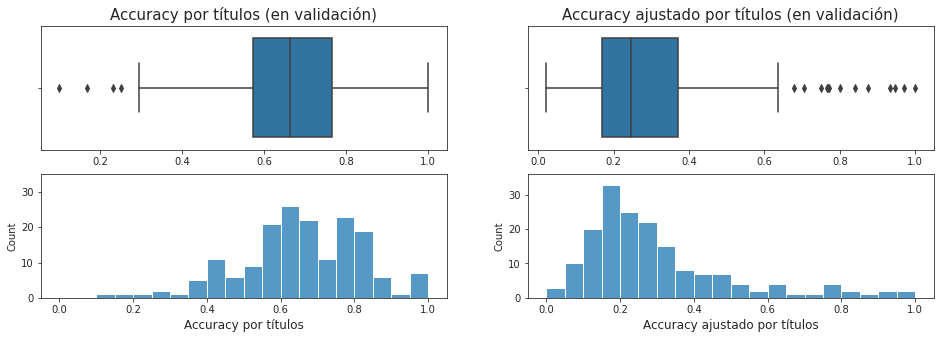

In [72]:
sns.set_style('ticks')

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2,figsize=(16,5))
font_titles=15
font_labels=12

sns.boxplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
            x='accuracy regresor')
ax1.set_title('Accuracy por títulos (en validación)',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

sns.boxplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
            x='accuracy ajustado regresor')
ax2.set_title('Accuracy ajustado por títulos (en validación)',fontsize=font_titles)
ax2.set_xlabel('',fontsize=font_labels)

sns.histplot(ax=ax3,data=naive_5_05_evalua_accuracy_vld,
             x='accuracy regresor',
             bins=np.arange(0,1.05,0.05))
ax3.set_xlabel('Accuracy por títulos',fontsize=font_labels)
ax3.set_ylim(0,35)

sns.histplot(ax=ax4,data=naive_5_05_evalua_accuracy_vld,
             x='accuracy ajustado regresor',
             bins=np.arange(0,1.05,0.05))
ax4.set_xlabel('Accuracy ajustado por títulos',fontsize=font_labels)
ax4.set_ylim(0,36)

fig.subplots_adjust(hspace=.2)
plt.show()

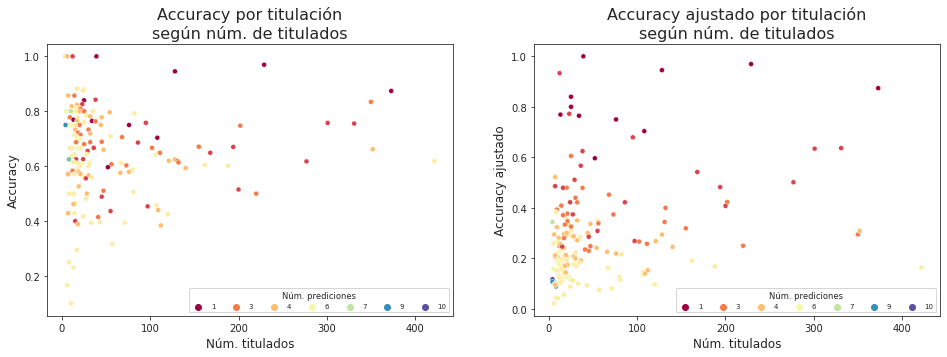

In [224]:
sns.set_style('ticks')

fig, ax = plt.subplots(1, 2,figsize=(16,5))
font_titles=16
font_labels=12

for i,col in enumerate(['accuracy regresor','accuracy ajustado regresor']):

    sns.scatterplot(ax=ax[i],data=naive_5_05_evalua_accuracy_vld,
                    x='num obs regresor',
                    y=col,
                    hue='num pred por regresor',
                    palette=sns.color_palette('Spectral', as_cmap=True),s=25)
    
    ax[i].set_xlabel('Núm. titulados',fontsize=font_labels)
    ax[i].legend(ncol=7,loc='best',title='Núm. prediciones',fontsize='x-small',title_fontsize='small')
    
    
titulo_0='Accuracy por titulación según núm. de titulados'
ax[0].set_title(textwrap.fill(titulo_0,25),fontsize=font_titles) 
ax[0].set_ylabel('Accuracy',fontsize=font_labels)

titulo_1='Accuracy ajustado por titulación según núm. de titulados'
ax[1].set_title(textwrap.fill(titulo_1,35),fontsize=font_titles) 
ax[1].set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [74]:
naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy regresor']].corr()

,num obs regresor,accuracy regresor
num obs regresor,1.000000,0.044836
accuracy regresor,0.044836,1.000000


In [75]:
naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy ajustado regresor']].corr()

,num obs regresor,accuracy ajustado regresor
num obs regresor,1.000000,0.271382
accuracy ajustado regresor,0.271382,1.000000


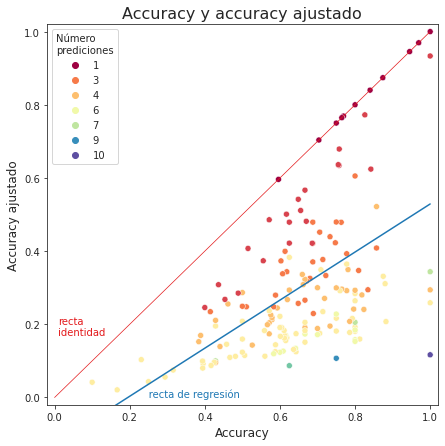

In [152]:
colores=sns.color_palette('Paired')
colores.as_hex()

sns.set_style('ticks')

fig, ax = plt.subplots(1, 1,figsize=(7,7))
font_titles=16
font_labels=12

x=np.arange(0,1,0.001)
plt.plot(x,x,color=colores.as_hex()[5],linewidth=0.7) # recta identidad

sns.regplot(data=naive_5_05_evalua_accuracy_vld,
            x='accuracy regresor', 
            y='accuracy ajustado regresor',
            ci=None,scatter=False,line_kws={'linewidth':1.5},color=colores.as_hex()[1])

sns.scatterplot(data=naive_5_05_evalua_accuracy_vld,
            x='accuracy regresor', 
            y='accuracy ajustado regresor',
            hue='num pred por regresor',palette=sns.color_palette('Spectral', as_cmap=True))

ax.set_title('Accuracy y accuracy ajustado',fontsize=font_titles) 
ax.set_xlabel('Accuracy',fontsize=font_labels)
ax.set_xlim(-0.02,1.02)
ax.set_ylabel('Accuracy ajustado',fontsize=font_labels)
ax.set_ylim(-0.02,1.02)
ax.legend(title='Número\nprediciones')
ax.text(x=0.2,y=0,s='      recta de regresión',color=colores.as_hex()[1])
ax.text(x=0.01,y=0.17,s='recta\nidentidad',color=colores.as_hex()[5])

plt.show()

In [77]:
naive_5_05_evalua_accuracy_vld[['accuracy regresor','accuracy ajustado regresor']].corr()

,accuracy regresor,accuracy ajustado regresor
accuracy regresor,1.00000,0.53621
accuracy ajustado regresor,0.53621,1.00000


In [78]:
explora_accuracy=naive_5_05_evalua_accuracy_vld

explora_accuracy['dif acc']=explora_accuracy['accuracy regresor']-explora_accuracy['accuracy ajustado regresor']
explora_accuracy[explora_accuracy['dif acc']<.1].sort_values(by=['accuracy regresor','dif acc'],ascending=False)
# Los puntos próximos a la recta identidad: 

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion,dif acc
regresor: titulo_ppal_,,,,,,,,,,,,
Máster Odontología,2,3,12,12,11.200000,1.000000,0.933333,0.001253,0.001253,0.001170,0.978261,0.066667
Grado Odontología,1,5,39,39,39.000000,1.000000,1.000000,0.004073,0.004073,0.004073,0.961290,0.000000
Grado Medicina,1,8,229,222,222.000000,0.969432,0.969432,0.023916,0.023185,0.023185,0.986914,0.000000
Grado Fisioterapia,1,20,128,121,121.000000,0.945312,0.945312,0.013368,0.012637,0.012637,0.914230,0.000000
Grado Enfermería,1,31,373,326,326.000000,0.873995,0.873995,0.038956,0.034047,0.034047,0.906103,0.000000
Grado Podología,1,11,25,21,21.000000,0.840000,0.840000,0.002611,0.002193,0.002193,0.861386,0.000000
Máster Medicina,2,12,23,19,17.766234,0.826087,0.772445,0.002402,0.001984,0.001855,0.827957,0.053642
Máster Enfermería,1,7,25,20,20.000000,0.800000,0.800000,0.002611,0.002089,0.002089,0.919192,0.000000
Máster Formación de docentes de enseñanza primaria,1,11,13,10,10.000000,0.769231,0.769231,0.001358,0.001044,0.001044,0.769231,0.000000


In [79]:
# Ilustra conveniencia de accuracy ajustado: 
explora_accuracy[explora_accuracy.index=='Máster Servicios de transporte']


# Incluir posición predicción acertada

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion,dif acc
regresor: titulo_ppal_,,,,,,,,,,,,
Máster Servicios de transporte,5,19,10,1,0.416667,0.1,0.041667,0.001044,0.000104,0.000044,0.571429,0.058333


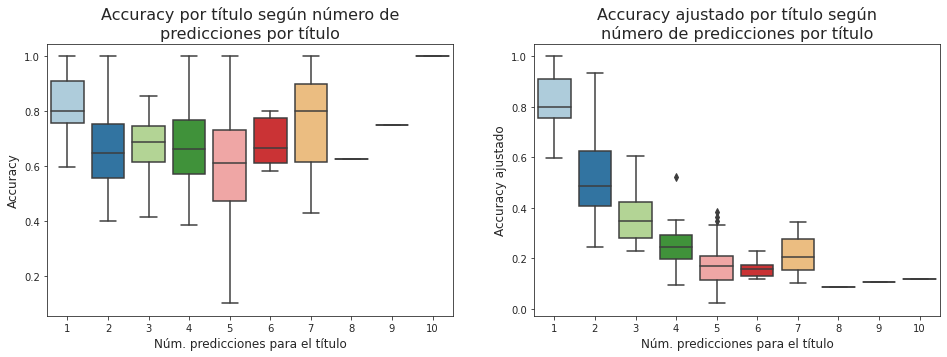

In [80]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=16
font_labels=12

sns.boxplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='num pred por regresor',
                y='accuracy regresor',
                palette='Paired')
titulo_1='Accuracy por título según número de predicciones por título'
ax1.set_title(textwrap.fill(titulo_1,35),fontsize=font_titles) 
ax1.set_xlabel('Núm. predicciones para el título',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)

sns.boxplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='num pred por regresor',
                y='accuracy ajustado regresor',
                palette='Paired')
titulo_2='Accuracy ajustado por título según número de predicciones por título'
ax2.set_title(textwrap.fill(titulo_2,35),fontsize=font_titles) 
ax2.set_xlabel('Núm. predicciones para el título',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [81]:
# El accuracy decrece con el núm de predicciones porque más predicciones se deben a menos concentración en las 
# ocupaciones de los titulados y más dificultad para predecir (hasta que se hacen demasiadas predicciones)
# En el no ajustado esto se compensa en parte con más probabilidad de acertar (más intentos).
# En el ajustado no hay compensación porque las predicciones débiles puntuan menos

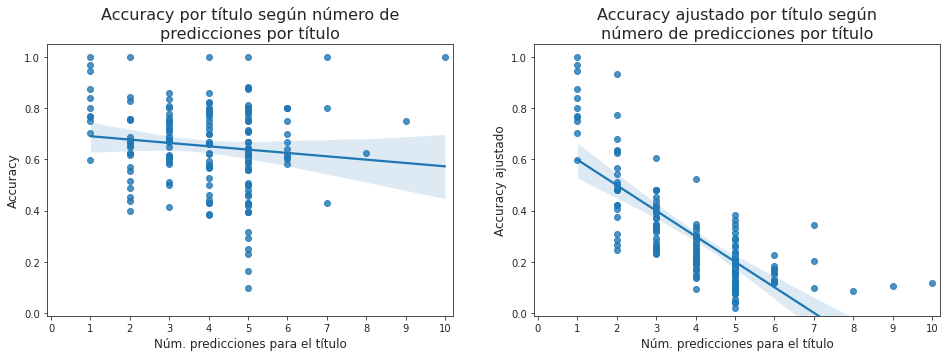

In [82]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=16
font_labels=12

sns.regplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='num pred por regresor',
                y='accuracy regresor')

titulo_1='Accuracy por título según número de predicciones por título'
ax1.set_title(textwrap.fill(titulo_1,35),fontsize=font_titles) 
ax1.set_xlabel('Núm. predicciones para el título',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)
ax1.set_xlim(-0.1,10.2)
ax1.set_ylim(-0.01,1.05)
ax1.set_xticks(np.arange(0,11,1))

sns.regplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='num pred por regresor',
                y='accuracy ajustado regresor')
titulo_2='Accuracy ajustado por título según número de predicciones por título'
ax2.set_title(textwrap.fill(titulo_2,35),fontsize=font_titles) 
ax2.set_xlabel('Núm. predicciones para el título',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)
ax2.set_xlim(-0.1,10.2)
ax2.set_ylim(-0.01,1.05)
ax2.set_xticks(np.arange(0,11,1))

fig.subplots_adjust(hspace=.5)
plt.show()

In [83]:
naive_5_05_evalua_accuracy_vld[['num pred por regresor','accuracy regresor']].corr()

,num pred por regresor,accuracy regresor
num pred por regresor,1.000000,-0.124194
accuracy regresor,-0.124194,1.000000


In [84]:
naive_5_05_evalua_accuracy_vld[['num pred por regresor','accuracy ajustado regresor']].corr()

,num pred por regresor,accuracy ajustado regresor
num pred por regresor,1.000000,-0.772964
accuracy ajustado regresor,-0.772964,1.000000


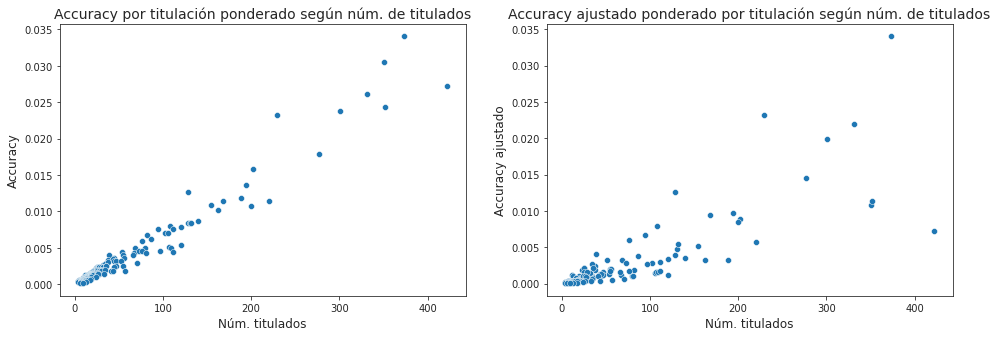

In [85]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.scatterplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='num obs regresor',
                y='accuracy ponderado regresor')
ax1.set_title('Accuracy por titulación ponderado según núm. de titulados',fontsize=font_titles) 
ax1.set_xlabel('Núm. titulados',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)

# Destacar los ac=ac ajustado

sns.scatterplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='num obs regresor',
                y='accuracy ajustado ponderado regresor')
ax2.set_title('Accuracy ajustado ponderado por titulación según núm. de titulados',fontsize=font_titles) 
ax2.set_xlabel('Núm. titulados',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [86]:
# Accuracy ajustado minora el efecto de ponderación por núm. de titulados: las titulaciones con más peso 
# (más titulados) pesan más en el agregado porque tienen ponderación más fuerte . Esto oculta que pueden 
# tener predicciones menos firmes (más ocupaciones posibles, menos prob). El accuracy ajustado corrige este
# efecto. 
# Naturalmente, el accuracy ponderado es creciente con el núm. de titulados. 
#######################################################Cuidado con el eje y arriba

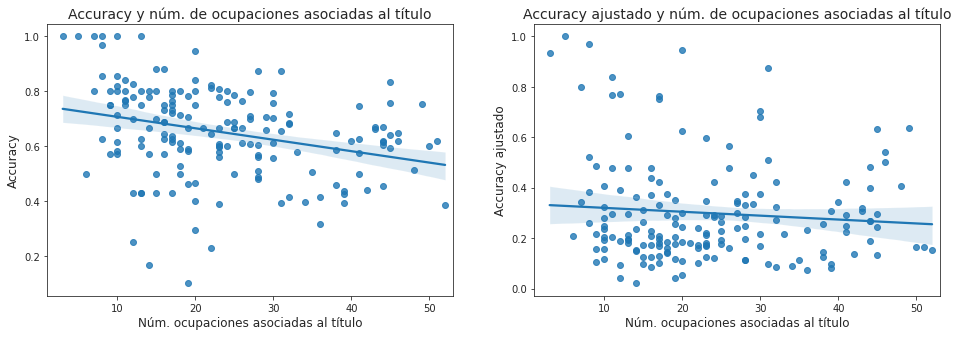

In [87]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.regplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='cat target por regresor (train)',
                y='accuracy regresor')
ax1.set_title('Accuracy y núm. de ocupaciones asociadas al título',fontsize=font_titles) 
ax1.set_xlabel('Núm. ocupaciones asociadas al título',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)
ax1.set_xlim(1,53)

sns.regplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='cat target por regresor (train)',
                y='accuracy ajustado regresor')
ax2.set_title('Accuracy ajustado y núm. de ocupaciones asociadas al título',fontsize=font_titles) 
ax2.set_xlabel('Núm. ocupaciones asociadas al título',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)
ax2.set_xlim(1,53)

fig.subplots_adjust(hspace=.5)
plt.show()

In [88]:
naive_5_05_evalua_accuracy_vld[['cat target por regresor (train)','accuracy regresor']].corr()

,cat target por regresor (train),accuracy regresor
cat target por regresor (train),1.000000,-0.296754
accuracy regresor,-0.296754,1.000000


In [89]:
naive_5_05_evalua_accuracy_vld[['cat target por regresor (train)','accuracy ajustado regresor']].corr()

,cat target por regresor (train),accuracy ajustado regresor
cat target por regresor (train),1.000000,-0.089719
accuracy ajustado regresor,-0.089719,1.000000


# Métricas de evaluación: recall

In [90]:
def naive_evalua_recall(clasificador,data):
    
    evalua=naive_evalua(clasificador=clasificador,data=data)
    
    import re
    lista_re_target=list(filter(lambda col: re.search('.*target.*',col),evalua.columns))
    lista_re_target=list(filter(lambda col: re.search('^(?!.*regresor.*)',col),lista_re_target))
    
    evalua=evalua[lista_re_target].drop_duplicates()
    evalua.set_index(evalua.columns[0],inplace=True)
    evalua.sort_values(by='recall target',ascending=False,inplace=True)

    return evalua

In [91]:
naive_5_05_evalua_recall_vld=naive_evalua_recall(clasificador=naive_5_05_train,data=df_vld)

In [92]:
naive_5_05_evalua_recall_vld.shape, df_vld['ocupacion_'].nunique() # Comprobación

((60, 8), 60)

In [93]:
naive_5_05_evalua_recall_vld.head()

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
target: ocupacion_,,,,,,,,
Prof sanitarios,1205,1122,1031.199836,0.931120,0.855767,0.125849,0.117180,0.107697
"Prof ciencias, matemáticas e ingeniería",1246,1151,726.562511,0.923756,0.583116,0.130131,0.120209,0.075881
Prof enseñanza,1580,1400,956.548865,0.886076,0.605411,0.165013,0.146214,0.099901
Prof derecho,266,224,122.352684,0.842105,0.459972,0.027781,0.023394,0.012778
Técnicos ciencias e ingenierías,325,255,61.832153,0.784615,0.190253,0.033943,0.026632,0.006458


In [94]:
naive_5_05_evalua_recall_vld.tail()

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
target: ocupacion_,,,,,,,,
Comerciantes propietarios de tiendas,7,0,0.0,0.0,0.0,0.000731,0.0,0.0
"Trabajadores ind alimentación, bebidas y tabaco",9,0,0.0,0.0,0.0,0.000940,0.0,0.0
Trabajadores construcción y afines: estructura,7,0,0.0,0.0,0.0,0.000731,0.0,0.0
Gerentes en servicios excepto hostelería y comercio,37,0,0.0,0.0,0.0,0.003864,0.0,0.0
"Trabajadores cualif act forestales, pesqueras, cinegéticas",2,0,0.0,0.0,0.0,0.000209,0.0,0.0


In [95]:
#with pd.option_context("display.max_rows", naive_5_05_evalua_recall_vld.shape[0]):
#    display(naive_5_05_evalua_recall_vld)

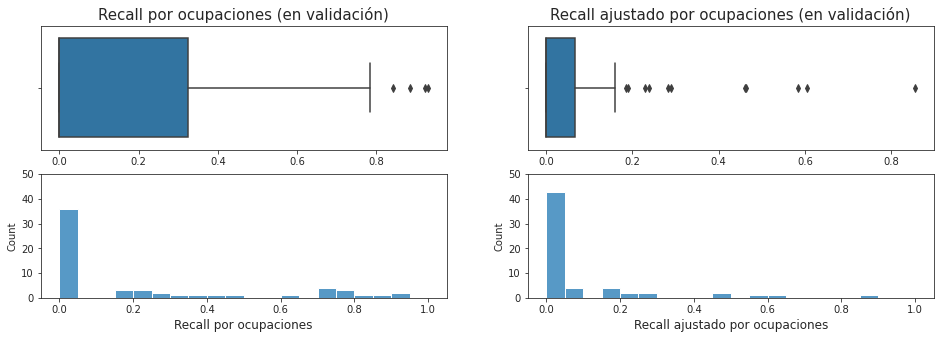

In [96]:
sns.set_style('ticks')

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2,figsize=(16,5))
font_titles=15
font_labels=12

sns.boxplot(ax=ax1,data=naive_5_05_evalua_recall_vld,x='recall target')
ax1.set_title('Recall por ocupaciones (en validación)',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

sns.boxplot(ax=ax2,data=naive_5_05_evalua_recall_vld,x='recall ajustado target')
ax2.set_title('Recall ajustado por ocupaciones (en validación)',fontsize=font_titles)
ax2.set_xlabel('',fontsize=font_labels)

sns.histplot(ax=ax3,data=naive_5_05_evalua_recall_vld,x='recall target',bins=np.arange(0,1.05,0.05))
ax3.set_xlabel('Recall por ocupaciones',fontsize=font_labels)
ax3.set_ylim(0,50)

sns.histplot(ax=ax4,data=naive_5_05_evalua_recall_vld,x='recall ajustado target',bins=np.arange(0,1.05,0.05))
ax4.set_xlabel('Recall ajustado por ocupaciones',fontsize=font_labels)
ax4.set_ylim(0,50)

fig.subplots_adjust(hspace=.2)
plt.show()

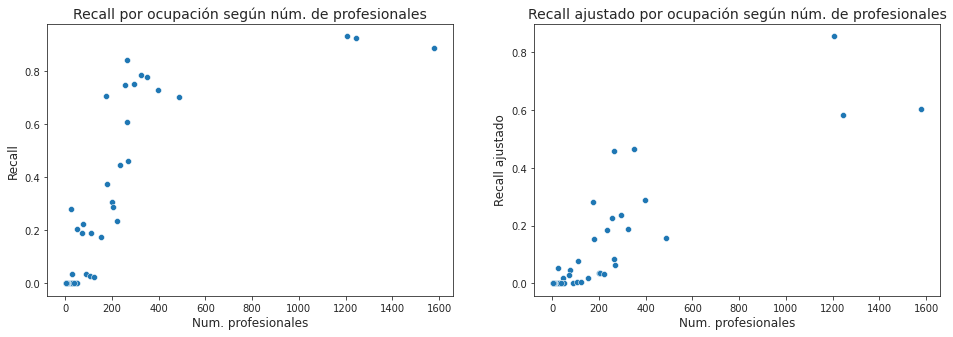

In [97]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12


sns.scatterplot(ax=ax1,data=naive_5_05_evalua_recall_vld,x='num obs target',y='recall target')
ax1.set_title('Recall por ocupación según núm. de profesionales',fontsize=font_titles)
ax1.set_xlabel('Num. profesionales',fontsize=font_labels)
ax1.set_ylabel('Recall',fontsize=font_labels)

sns.scatterplot(ax=ax2,data=naive_5_05_evalua_recall_vld,x='num obs target',y='recall ajustado target')
ax2.set_title('Recall ajustado por ocupación según núm. de profesionales',fontsize=font_titles)
ax2.set_xlabel('Num. profesionales',fontsize=font_labels)
ax2.set_ylabel('Recall ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [98]:
display(naive_5_05_evalua_recall_vld[['num obs target','recall target']].corr(),
        naive_5_05_evalua_recall_vld[['num obs target','recall ajustado target']].corr())

,num obs target,recall target
num obs target,1.000000,0.773547
recall target,0.773547,1.000000


,num obs target,recall ajustado target
num obs target,1.000000,0.882196
recall ajustado target,0.882196,1.000000


## Conclusiones

###### 1. El rendimiento evaluado por títulos (accuracy) es muy superior al recall evaluado por ocupaciones    

- El dataset es una **encuesta sobre titulados universitarios**: el muestreo está diseñado para garantizar una presencia representativa de los títulos universitarios, no de las ocupaciones profesionales. Los puestos de trabajo que no requieren formación universitaria están infrarepresentados respecto a su peso en la población general.  


###### 2. El accuracy para cada título es poco dependiente del número de egresados de la titulación     

###### 3. El recall por ocupaciones tiene una relación fuerte y directa con el número de profesionales encuestados  

- El **peor rendimiento** se da, sobre todo, en **ocupaciones que no requieren titulación universitaria**: las ocupaciones con **recall nulo** son profesiones no cualificadas u ocupaciones cuya formación especializada es no universitaria, con las excepciones de los profesionales en política y dirección de la Administración Pública y los profesionales de apoyo en finanzas y matemáticas. 
- Las ocupaciones con recall nulo son, también, las más infrarepresentadas en la encuesta. 

# Metricas de evaluación: precisión

In [99]:
# Dataframe para pruebas de función naive_evalua_rhs: 
df_prueba=pd.DataFrame({'titulo_ppal_':['Grado Derecho','Grado Derecho','Grado Derecho',
                                        'Grado Administración y empresa','Grado Medicina'],
                        'ocupacion_':['Prof derecho','Prof derecho',
                                      'Empleados servicios financieros, contables y de apoyo','Prof derecho',
                                      'Prof sanitarios']},
                       index=[50,51,52,53,54])

In [100]:
def naive_evalua_rhs(clasificador, data):
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0].split(' ')[1]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0].split(' ')[1]
    
    evalua=data[[regresor,target]]
    
    total_obs=evalua.shape[0]
    
    # Num. de observaciones para cada categoría del target (numerador pesos de precisiones ponderadas):
    total_obs_por_cat_target=evalua.groupby(target).agg(['count']) # cuenta sobre target observado
    total_obs_por_cat_target.columns=total_obs_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_target,on=target,how='outer') 
    evalua.rename(columns={evalua.columns[-1]:'num obs cat target'},inplace=True)
    
    # Columnas con predicciones (lista targets predichos y lista probabilidades)
    evalua['prediccion']=evalua[regresor]\
                         .apply(lambda valor: naive_predice(clasificador,valor)['prediccion'].tolist())
    evalua['prediccion probs']=evalua[regresor]\
                         .apply(lambda valor: naive_predice(clasificador,valor)['probabilidad'].tolist())
    
    # Columna 'suma de prob. de pred. por regresor' (denominador de acierto ajustado por probabilidad):
    # Se hace aquí para eleminar listas del dataframe (interfieren en comparaciones de filas)
    evalua['suma prob pred por regresor']=evalua['prediccion probs'].apply(lambda lista: sum(lista))
    
    # Núm predicciones:
    evalua['num pred para regresor']=evalua['prediccion'].apply(lambda lista:len(lista))
    max_rank=evalua['num pred para regresor'].max()
    
    for i in range(max_rank):
        # Se sacan las predicciones de la lista y se convierten en columnas:  
        evalua['pred'+str(i)]=evalua['prediccion'][evalua['num pred para regresor']>=i+1]\
                             .apply(lambda lista:lista[i])
        # Se sacan las probabilidades de las predicciones de la lista y se convierten en columnas: 
        evalua['p'+str(i)]=evalua['prediccion probs'][evalua['num pred para regresor']>=i+1]\
                          .apply(lambda lista:lista[i])   

    del evalua['prediccion'], evalua['prediccion probs'] # listas interfieren en comparaciones de filas
    
    # Se odenan todas la predicciones para una observacion (previamente en cols) en filas:
    # Para cada obs., una fila por predicción: filas dénticas salvo por el valor de la predicción y su prob. 
    # Las obs. dejan de corresponderse con filas (varias pred. para una obs.)
    # Las predicciones ordenadas en 2 columnas: predicciones del target y prob. de las predicciones
    
    evalua.rename(columns={'pred0':'predicciones target','p0':'predicciones prob'},inplace=True)
    
    for i in range(1,max_rank):
        aux=evalua[evalua.columns.drop(['predicciones target','predicciones prob'])]
        aux.rename(columns={'pred'+str(i):'predicciones target','p'+str(i):'predicciones prob'},inplace=True)     
        # Prescinde de filas con nan por titulaciones con menos predicciones que otras: 
        aux=aux[aux['predicciones target'].notna()]
        del evalua['pred'+str(i)], evalua['p'+str(i)]
        # Merge conservando índices para identificar observaciones distintas (no se corresponden con filas):
        for df in [evalua,aux]:
            df.reset_index(inplace=True)
        evalua=evalua.merge(aux,how='outer')
        evalua.drop_duplicates(inplace=True)
        evalua.set_index('index',inplace=True)
    
    # Para desligar por índice y asignar valores distintos en col. nuevas para misma obs.: 
    evalua.reset_index(drop=False,inplace=True) 
    evalua.sort_values(by='index',inplace=True)
    
    # Aciertos (binaria):
    evalua['acierto']=0
    evalua['acierto'].mask(evalua['predicciones target']==evalua[target],1,inplace=True)
   
    # Probabilidades de las predicciones acertadas:
    evalua['prob pred acertada']=evalua[evalua['acierto']==1]['predicciones prob']
    
    # Núm. de aciertos (binaria) para cada predicción: 
    aciertos_por_prediccion=evalua[['predicciones target','acierto']].groupby('predicciones target').agg(['sum'])
    aciertos_por_prediccion.columns=aciertos_por_prediccion.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_prediccion,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'num pred acertadas'},inplace=True)
    
    # Núm. de repeticiones de cada predicción: 
    repeticiones_pred=evalua[['predicciones target','acierto']].groupby('predicciones target').agg(['count'])
    repeticiones_pred.columns=repeticiones_pred.columns.to_flat_index()
    evalua=evalua.merge(repeticiones_pred,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'num pred'},inplace=True)

    # Acierto ajustado: proporción de la probabilidad de predicción acertada sobre suma probs. de predicciones:  
    evalua['acierto ajustado']=evalua[evalua['acierto']==1]['prob pred acertada']\
                              .div(evalua[evalua['acierto']==1]['suma prob pred por regresor'])

    # Suma aciertos ajustados para cada predicción: 
    suma_aciertos_ajustados=evalua[['predicciones target','acierto ajustado']]\
                                           .groupby('predicciones target').agg(['sum'])
    suma_aciertos_ajustados.columns=suma_aciertos_ajustados.columns.to_flat_index()
    evalua=evalua.merge(suma_aciertos_ajustados,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por pred'},inplace=True)
    
    # Precisión y precisión ajustada por predicción: 
    evalua['precision pred']=evalua['num pred acertadas'].div(evalua['num pred'])
    evalua['precision ajustada pred']=evalua['aciertos ajustados por pred']\
                                          .div(evalua['num pred'])
   
    # Pesos de predicciones = num. obs. de target predicho entre total obs.: 
    pesos_pred=evalua[[target,'num obs cat target']]
    pesos_pred['peso pred']=pesos_pred['num obs cat target']/total_obs
    pesos_pred=pesos_pred[[target,'peso pred']]
    pesos_pred.rename(columns={target:'predicciones target'},inplace=True)
    pesos_pred.drop_duplicates(inplace=True)
    evalua=evalua.merge(pesos_pred,on='predicciones target',how='left')
    evalua['peso pred'].fillna(0,inplace=True) # para predicciones no observadas
    
    # Precisión y precisión ajustada ponderada para cada predicción:    
    evalua['precision ponderada pred']=evalua['precision pred']*evalua['peso pred']
    evalua['precision ajustada ponderada pred']=evalua['precision ajustada pred']*evalua['peso pred']
    
    # Formato:
    evalua.set_index('index',inplace=True)
    evalua.sort_index(inplace=True)
    evalua.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)

    return evalua

In [101]:
prueba=naive_evalua_rhs(clasificador=naive_5_05_train, data=df_prueba)
prueba

,regresor: titulo_ppal_,target: ocupacion_,num obs cat target,suma prob pred por regresor,num pred para regresor,predicciones target,predicciones prob,acierto,prob pred acertada,num pred acertadas,num pred,acierto ajustado,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
index,,,,,,,,,,,,,,,,,,
0,Grado Derecho,Prof derecho,3,0.666667,4,Prof derecho,0.428571,1,0.428571,3,4,0.642857,1.376355,0.75,0.344089,0.6,0.45,0.206453
0,Grado Derecho,Prof derecho,3,0.666667,4,"Expertos en gestión, finanzas, comercio, etc",0.087420,0,NaN,0,4,NaN,0.000000,0.00,0.000000,0.0,0.00,0.000000
0,Grado Derecho,Prof derecho,3,0.666667,4,Empleados administrativos sin atención al público,0.060412,0,NaN,0,4,NaN,0.000000,0.00,0.000000,0.0,0.00,0.000000
0,Grado Derecho,Prof derecho,3,0.666667,4,"Empleados servicios financieros, contables y de apoyo",0.090263,0,NaN,1,4,NaN,0.135394,0.25,0.033849,0.2,0.05,0.006770
1,Grado Derecho,Prof derecho,3,0.666667,4,Empleados administrativos sin atención al público,0.060412,0,NaN,0,4,NaN,0.000000,0.00,0.000000,0.0,0.00,0.000000
1,Grado Derecho,Prof derecho,3,0.666667,4,"Empleados servicios financieros, contables y de apoyo",0.090263,0,NaN,1,4,NaN,0.135394,0.25,0.033849,0.2,0.05,0.006770
1,Grado Derecho,Prof derecho,3,0.666667,4,Prof derecho,0.428571,1,0.428571,3,4,0.642857,1.376355,0.75,0.344089,0.6,0.45,0.206453
1,Grado Derecho,Prof derecho,3,0.666667,4,"Expertos en gestión, finanzas, comercio, etc",0.087420,0,NaN,0,4,NaN,0.000000,0.00,0.000000,0.0,0.00,0.000000
2,Grado Administración y empresa,Prof derecho,3,0.601303,5,Prof derecho,0.054502,1,0.054502,3,4,0.090640,1.376355,0.75,0.344089,0.6,0.45,0.206453


### Evaluación desagregada (en validación) 

In [102]:
naive_5_05_evalua_rhs_vld=naive_evalua_rhs(clasificador=naive_5_05_train, data=df_vld)

In [103]:
naive_5_05_evalua_rhs_vld.head()

,regresor: titulo_ppal_,target: ocupacion_,num obs cat target,suma prob pred por regresor,num pred para regresor,predicciones target,predicciones prob,acierto,prob pred acertada,num pred acertadas,num pred,acierto ajustado,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
index,,,,,,,,,,,,,,,,,,
0,Grado Periodismo,Prof enseñanza,1580,0.541071,4,Prof cultura y espectáculo,0.328571,0,NaN,124,903,NaN,49.765377,0.137320,0.055111,0.018381,0.002524,0.001013
0,Grado Periodismo,Prof enseñanza,1580,0.541071,4,"Expertos en gestión, finanzas, comercio, etc",0.096429,0,NaN,342,2921,NaN,77.633882,0.117083,0.026578,0.050966,0.005967,0.001355
0,Grado Periodismo,Prof enseñanza,1580,0.541071,4,Directores Admón y comerciales,0.050000,0,NaN,27,557,NaN,3.170150,0.048474,0.005691,0.016188,0.000785,0.000092
0,Grado Periodismo,Prof enseñanza,1580,0.541071,4,Técnicos TI,0.066071,0,NaN,191,1049,NaN,58.386838,0.182078,0.055660,0.026736,0.004868,0.001488
1,Máster Maquinaria y metalurgia,Prof enseñanza,1580,0.653543,3,Prof enseñanza,0.094488,1,0.094488,1400,4597,0.144578,956.548865,0.304546,0.208081,0.165013,0.050254,0.034336


In [104]:
naive_5_05_evalua_rhs_vld['predicciones target'].nunique()
# Núm. de predicciones distintas:

34

In [105]:
naive_5_05_evalua_rhs_vld['target: ocupacion_'].nunique()
# Núm. de ocupaciones distintas observadas: 

60

## Precisión agregada por predicciones

In [106]:
def naive_evalua_precision(clasificador,data):
    
    """
    
    """
    
    evalua=naive_evalua_rhs(clasificador=clasificador,data=data)
    
    import re
    lista_re_pred=list(filter(lambda col: re.search('.*pred.*',col),evalua.columns))
    lista_re_pred=list(filter(lambda col: re.search('^(?!.*regresor.*)',col),lista_re_pred))
    lista_re_pred=list(filter(lambda col: re.search('^(?!.*prob.*)',col),lista_re_pred))
    lista_re_pred=[lista_re_pred[0]]+[lista_re_pred[2]]+[lista_re_pred[1]]+lista_re_pred[3:]
    
    evalua=evalua[lista_re_pred].drop_duplicates()
    
    evalua.set_index('predicciones target',inplace=True)
    evalua.sort_values(by='precision pred',ascending=False,inplace=True)

    return evalua

In [107]:
naive_5_05_precision_vld=naive_evalua_precision(clasificador=naive_5_05_train,data=df_vld)

In [108]:
naive_5_05_precision_vld.shape[0], df_vld['ocupacion_'].nunique() # Comprobación: 
# El núm de ocupaciones predichas es la cuarta parte del núm. de ocupaciones observadas en validación

(34, 60)

In [109]:
naive_5_05_precision_vld

,num pred,num pred acertadas,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
predicciones target,,,,,,,,
Prof sanitarios,1947,1122,1031.199836,0.576271,0.529635,0.125849,0.072523,0.066654
"Prof ciencias, matemáticas e ingeniería",3455,1151,726.562511,0.333140,0.210293,0.130131,0.043352,0.027366
Prof enseñanza,4597,1400,956.548865,0.304546,0.208081,0.165013,0.050254,0.034336
Gerentes hostelería y comercio,4,1,0.066667,0.250000,0.016667,0.002924,0.000731,0.000049
Prof derecho,945,224,122.352684,0.237037,0.129474,0.027781,0.006585,0.003597
"Empleados bibliotecas, correos, etc",30,7,1.354839,0.233333,0.045161,0.002611,0.000609,0.000118
Prof ciencias sociales,1341,271,162.098980,0.202088,0.120879,0.036449,0.007366,0.004406
Técnicos TI,1049,191,58.386838,0.182078,0.055660,0.026736,0.004868,0.001488
"Empleados servicios financieros, contables y de apoyo",1672,290,115.624553,0.173445,0.069153,0.041567,0.007210,0.002874


# Resúmenes de métricas de evaluación 

In [110]:
def naive_evalua_criterio_resumen(clasificador,data,criterio):
    """ Función instrumental: generaliza el proceso de resumen de la evaluación de acuerdo con un 'criterio' 
    que se concretará como accuracy, como recall o como precision.
    """
    if criterio=='accuracy':
        evalua=naive_evalua_accuracy(clasificador=clasificador,data=data)
    if criterio=='recall':
        evalua=naive_evalua_recall(clasificador=clasificador,data=data)
    if criterio=='precision':
        evalua=naive_evalua_precision(clasificador=clasificador,data=data)
    
    evalua_resumen=evalua.agg(['sum','mean','median','min','argmin','max','argmax'])
    
    # Ajustes argmin y argmax: 
    for col in evalua.columns: 
        for arg in ['argmin','argmax']:
            indice=int(evalua_resumen.loc[arg,col])
            evalua_resumen.loc[arg,col]=evalua.index[indice]

    return evalua_resumen

In [111]:
def naive_evalua_accuracy_resumen(clasificador,data):
    
    evalua=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='accuracy')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','accuracy regresor']=''
    evalua.loc['sum','accuracy ajustado regresor']=''
    
    return evalua

In [112]:
def naive_evalua_recall_resumen(clasificador,data):
    
    evalua=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='recall')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','recall target']=''
    evalua.loc['sum','recall ajustado target']=''
    
    return evalua

In [113]:
def naive_evalua_precision_resumen(clasificador,data):
    
    evalua=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='precision')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','precision pred']=''
    evalua.loc['sum','precision ajustada pred']=''
    
    return evalua

In [114]:
naive_5_05_evalua_accuracy_resumen_vld=naive_evalua_accuracy_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_accuracy_resumen_vld

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion
sum,693,4043,9575,6331,3585.43,,,1,0.661201,0.374457,120.977
mean,4.00578,23.3699,55.3468,36.5954,20.725,0.65112,0.299702,0.00578035,0.00382197,0.00216449,0.699287
median,4,20,25,15,6.21212,0.661932,0.244672,0.00261097,0.00156658,0.000648786,0.69112
min,1,3,4,1,0.125,0.1,0.0208333,0.000417755,0.000104439,1.30548e-05,0.345455
argmin,Grado Odontología,Máster Odontología,Máster Hostelería,Grado Relaciones internacionales,Grado Relaciones internacionales,Máster Servicios de transporte,Grado Relaciones internacionales,Máster Hostelería,Grado Relaciones internacionales,Grado Relaciones internacionales,Grado Humanidades
max,10,52,422,326,326,1,1,0.0440731,0.034047,0.034047,1
argmax,Máster Hostelería,Grado Historia,Grado Administración y empresa,Grado Enfermería,Grado Enfermería,Máster Odontología,Grado Odontología,Grado Administración y empresa,Grado Enfermería,Grado Enfermería,Máster Religión y teología


In [115]:
naive_5_05_evalua_recall_resumen_vld=naive_evalua_recall_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_recall_resumen_vld

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
sum,9575,6331,3585.43,,,1,0.661201,0.374457
mean,159.583,105.517,59.7571,0.214796,0.0867732,0.0166667,0.01102,0.00624095
median,36.5,0,0,0,0,0.00381201,0,0
min,2,0,0,0,0,0.000208877,0,0
argmin,"Trabajadores cualif act forestales, pesqueras, cinegéticas",Peones de industrias manufactureras,Peones de industrias manufactureras,Peones de industrias manufactureras,Peones de industrias manufactureras,"Trabajadores cualif act forestales, pesqueras, cinegéticas",Peones de industrias manufactureras,Peones de industrias manufactureras
max,1580,1400,1031.2,0.93112,0.855767,0.165013,0.146214,0.107697
argmax,Prof enseñanza,Prof enseñanza,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof enseñanza,Prof enseñanza,Prof sanitarios


In [116]:
naive_5_05_evalua_precision_resumen_vld=naive_evalua_precision_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_precision_resumen_vld
# suma pesos pred != 1 : pesos de predicciones imputados por pesos observaciones

,num pred,num pred acertadas,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
sum,31763,6331,3585.43,,,0.957702,0.231918,0.151089
mean,934.206,186.206,105.454,0.124606,0.0542638,0.0281677,0.00682112,0.00444379
median,601.5,56,7.47034,0.0931484,0.0136335,0.0184856,0.0014979,0.000198076
min,4,0,0,0,0,0.000208877,0,0
argmin,Gerentes hostelería y comercio,Ocupaciones militares,Ocupaciones militares,Ocupaciones militares,Ocupaciones militares,"Trabajadores cualif act forestales, pesqueras, cinegéticas",Ocupaciones militares,Ocupaciones militares
max,4597,1400,1031.2,0.576271,0.529635,0.165013,0.0725229,0.0666538
argmax,Prof enseñanza,Prof enseñanza,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof enseñanza,Prof sanitarios,Prof sanitarios


# Evaluación: agregados 

In [117]:
def naive_evalua_regresor(clasificador,data):
    
    """Resume las métricas relacionadas con el accuracy para cada categoría del regresor a partir del clasificador
    entrenado y el set de datos de evaluación. 
    """
    
    import re
    
    resumen=naive_evalua_accuracy(clasificador=clasificador,data=data)
    lista_re_accuracy_1=list(filter(lambda col: re.search('.*accuracy.*',col),resumen.columns))
    lista_re_accuracy_2=list(filter(lambda col: re.search('.*peso.*',col),resumen.columns))
    resumen=resumen[lista_re_accuracy_1+lista_re_accuracy_2]
    resumen.index.rename('regresor',inplace=True)

    # Formato: 
    columnas=[resumen.columns[-1]]+resumen.columns[:-1].tolist()
    resumen=resumen[columnas]
    dicc_col=dict(zip(resumen.columns,list(map(lambda col: col.rsplit(' ',1)[0],resumen.columns))))
    resumen.rename(columns=dicc_col,inplace=True)
    resumen.sort_values(by='accuracy',ascending=False,inplace=True)

    return resumen

In [118]:
naive_5_05_regresor=naive_evalua_regresor(clasificador=naive_5_05_train,data=df_vld)

In [119]:
naive_5_05_regresor.sum()

peso                             1.000000
accuracy                       112.643824
accuracy ajustado               51.848451
accuracy ponderado               0.661201
accuracy ajustado ponderado      0.374457
dtype: float64

In [120]:
naive_5_05_regresor.head()

,peso,accuracy,accuracy ajustado,accuracy ponderado,accuracy ajustado ponderado
regresor,,,,,
Máster Odontología,0.001253,1.0,0.933333,0.001253,0.001170
Máster Hostelería,0.000418,1.0,0.116667,0.000418,0.000049
Máster Religión y teología,0.000418,1.0,0.343750,0.000418,0.000144
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",0.000522,1.0,0.258824,0.000522,0.000135
Máster Pesca,0.000627,1.0,0.294118,0.000627,0.000184


In [121]:
def naive_evalua_target(clasificador,data):
    
    """Resume las métricas relacionadas con la precisión y el recall para cada categoría del target a partir 
    del clasificador entrenado y el set de datos de evaluación. 
    """
    
    import re
    
    resumen_precision=naive_evalua_precision(clasificador=clasificador,data=data)
    lista_re_precision=list(filter(lambda col: re.search('.*precision.*',col),resumen_precision.columns))
    resumen_precision=resumen_precision[lista_re_precision]
    resumen_precision.index.rename('target',inplace=True)
    
    resumen_recall=naive_evalua_recall(clasificador=clasificador,data=data)
    lista_re_recall_1=list(filter(lambda col: re.search('.*recall.*',col),resumen_recall.columns))
    lista_re_recall_2=list(filter(lambda col: re.search('.*num.*',col),resumen_recall.columns)) 
    lista_re_recall_3=list(filter(lambda col: re.search('.*peso.*',col),resumen_recall.columns))
    resumen_recall=resumen_recall[lista_re_recall_1+lista_re_recall_2+lista_re_recall_3]
    resumen_recall.index.rename('target',inplace=True)
    
    resumen=resumen_precision.merge(resumen_recall,left_index=True,right_index=True,how='outer')

    # Formato: 
    columnas=resumen.columns[-3:].tolist()+resumen.columns[:-3].tolist()
    resumen=resumen[columnas]
    dicc_col=dict(zip(resumen.columns,list(map(lambda col: col.rsplit(' ',1)[0],resumen.columns))))
    dicc_col=dict(zip(dicc_col.keys(),list(map(lambda col: col.split('por')[0],dicc_col.values()))))
    resumen.rename(columns=dicc_col,inplace=True)
    resumen.sort_values(by=['num obs','precision','recall'],ascending=False,inplace=True)
    
    resumen['indice f1']=2*resumen['precision']*resumen['recall']/(resumen['precision']+resumen['recall'])
    resumen['indice f1 ajustado']=2*resumen['precision ajustada']*resumen['recall ajustado']\
                                  /(resumen['precision ajustada']+resumen['recall ajustado'])
    resumen['indice f1 ponderado']=resumen['indice f1']*resumen['peso']
    resumen['indice f1 ajustado ponderado']=resumen['indice f1 ajustado']*resumen['peso']

    return resumen

In [122]:
prueba=naive_evalua_target(clasificador=naive_5_05_train,data=df_prueba)
prueba

,num obs,num aciertos,peso,precision,precision ajustada,precision ponderada,precision ajustada ponderada,recall,recall ajustado,recall ponderado,recall ajustado ponderado,indice f1,indice f1 ajustado,indice f1 ponderado,indice f1 ajustado ponderado
target,,,,,,,,,,,,,,,
Prof derecho,3.0,3.0,0.6,0.75,0.344089,0.45,0.206453,1.0,0.458785,0.6,0.275271,0.857143,0.393244,0.514286,0.235947
Prof sanitarios,1.0,1.0,0.2,1.00,1.000000,0.20,0.200000,1.0,1.000000,0.2,0.200000,1.000000,1.000000,0.200000,0.200000
"Empleados servicios financieros, contables y de apoyo",1.0,1.0,0.2,0.25,0.033849,0.05,0.006770,1.0,0.135394,0.2,0.027079,0.400000,0.054158,0.080000,0.010832
Empleados administrativos sin atención al público,NaN,NaN,NaN,0.00,0.000000,0.00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Expertos en gestión, finanzas, comercio, etc",NaN,NaN,NaN,0.00,0.000000,0.00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Representantes e intermediarios,NaN,NaN,NaN,0.00,0.000000,0.00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
naive_5_05_target=naive_evalua_target(clasificador=naive_5_05_train,data=df_vld)

In [124]:
naive_5_05_target.sum()

num obs                         9575.000000
num aciertos                    6331.000000
peso                               1.000000
precision                          4.236601
precision ajustada                 1.844971
precision ponderada                0.231918
precision ajustada ponderada       0.151089
recall                            12.887789
recall ajustado                    5.206391
recall ponderado                   0.661201
recall ajustado ponderado          0.374457
indice f1                          5.838917
indice f1 ajustado                 2.601840
indice f1 ponderado                0.330748
indice f1 ajustado ponderado       0.209259
dtype: float64

In [125]:
naive_5_05_target.head()

,num obs,num aciertos,peso,precision,precision ajustada,precision ponderada,precision ajustada ponderada,recall,recall ajustado,recall ponderado,recall ajustado ponderado,indice f1,indice f1 ajustado,indice f1 ponderado,indice f1 ajustado ponderado
target,,,,,,,,,,,,,,,
Prof enseñanza,1580,1400,0.165013,0.304546,0.208081,0.050254,0.034336,0.886076,0.605411,0.146214,0.099901,0.453294,0.309713,0.074800,0.051107
"Prof ciencias, matemáticas e ingeniería",1246,1151,0.130131,0.333140,0.210293,0.043352,0.027366,0.923756,0.583116,0.120209,0.075881,0.489683,0.309110,0.063723,0.040225
Prof sanitarios,1205,1122,0.125849,0.576271,0.529635,0.072523,0.066654,0.931120,0.855767,0.117180,0.107697,0.711929,0.654315,0.089595,0.082345
"Expertos en gestión, finanzas, comercio, etc",488,342,0.050966,0.117083,0.026578,0.005967,0.001355,0.700820,0.159086,0.035718,0.008108,0.200645,0.045546,0.010226,0.002321
"Empleados servicios financieros, contables y de apoyo",398,290,0.041567,0.173445,0.069153,0.007210,0.002874,0.728643,0.290514,0.030287,0.012076,0.280193,0.111715,0.011647,0.004644


In [126]:
def naive_evalua_resumen(clasificador, data, nombre='naive'):
    
    resumen=naive_evalua_target(clasificador=clasificador, data=data)
    resumen=resumen[['precision ponderada', 'precision ajustada ponderada','recall ponderado',
                   'recall ajustado ponderado','indice f1 ponderado','indice f1 ajustado ponderado']]
    dicc_col=dict(zip(resumen.columns,map(lambda col: col.rsplit(' ',1)[0],resumen.columns)))
    resumen.rename(columns=dicc_col,inplace=True)
    resumen.rename(columns={'recall':'recall (o accuracy)'},inplace=True)
    
    resumen=pd.DataFrame(resumen.sum())
    resumen.rename(columns={resumen.columns[0]:str(nombre)},inplace=True)
    resumen.index.rename('medias ponderadas',inplace=True)
    
    return resumen

In [127]:
prueba=naive_evalua_resumen(clasificador=naive_5_05_train,data=df_prueba)
prueba

,naive
medias ponderadas,
precision,0.700000
precision ajustada,0.413223
recall (o accuracy),1.000000
recall ajustado,0.502350
indice f1,0.794286
indice f1 ajustado,0.446778


In [128]:
naive_5_05_resumen=naive_evalua_resumen(clasificador=naive_5_05_train,data=df_vld)

In [129]:
naive_5_05_resumen

,naive
medias ponderadas,
precision,0.231918
precision ajustada,0.151089
recall (o accuracy),0.661201
recall ajustado,0.374457
indice f1,0.330748
indice f1 ajustado,0.209259


In [130]:
naive_encuesta=naive_fit(data=df,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)

In [131]:
def naive_comparador(lista_clasificadores,lista_data):
    
    m=len(lista_clasificadores)
    if type(lista_data)!=list: 
        lista_data=[lista_data]*m
    resumen=naive_evalua_resumen(clasificador=lista_clasificadores[0], data=lista_data[0])
    #resumen.rename
    for i in range(1,m):
        evalua=naive_evalua_resumen(clasificador=lista_clasificadores[i], data=lista_data[i])
        resumen=pd.concat([resumen,evalua],axis=1)
        
    return resumen

In [132]:
prueba=naive_comparador([naive_5_05_train,naive_5_05_train],[df_prueba, df_prueba.sample(3)])
prueba

,naive,naive
medias ponderadas,,
precision,0.700000,0.555556
precision ajustada,0.413223,0.178043
recall (o accuracy),1.000000,1.000000
recall ajustado,0.502350,0.289631
indice f1,0.794286,0.700000
indice f1 ajustado,0.446778,0.218165
